# Install requirements


In [0]:
#!pip3 install 'torch==1.3.1'
!pip3 install 'torch==1.4.0'
!pip3 install 'torchvision==0.5.0'
!pip3 install 'Pillow-SIMD'
!pip3 install 'tqdm'

# Import libraries

In [1]:
import os
import logging

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader, random_split
from torch.backends import cudnn

import torchvision
from torchvision import transforms
from torchvision.models import alexnet

from PIL import Image
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from copy import deepcopy
import seaborn as sns
import cv2

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Set Arguments 

In [0]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 101 # 101 + 1: There is an extra Background class that should be removed 

BATCH_SIZE = 256     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 1e-3            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 30      # Total number of training epochs (iterations over dataset)
STEP_SIZE = 20       # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 10
VAL_FREQUENCY = 2

# Define Data Preprocessing

In [0]:
# Define transforms for training phase
train_transform = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.CenterCrop(224),  # Crops a central square patch of the image
                                                                   # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                   # Remember this when applying different transformations, otherwise you get an error
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalizes tensor with mean and standard deviation
])
# Define transforms for the evaluation phase
eval_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))                                    
])

# Prepare Dataset

In [4]:
# Clone github repository with data
if not os.path.isdir('./Caltech101'):
  !git clone https://github.com/MachineLearning2020/Homework2-Caltech101.git
  !mv 'Homework2-Caltech101' 'Caltech101'

Cloning into 'Homework2-Caltech101'...
remote: Enumerating objects: 9256, done.
remote: Total 9256 (delta 0), reused 0 (delta 0), pack-reused 9256
Receiving objects: 100% (9256/9256), 129.48 MiB | 12.30 MiB/s, done.
Resolving deltas: 100% (4/4), done.
Checking out files: 100% (9149/9149), done.


In [0]:
### caltech_dataset.py file ###

from torchvision.datasets import VisionDataset

from PIL import Image

import os
import os.path
import sys


def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

def make_dataset(directory, file, class_to_idx):
    instances_train = []
    instances_val = []
    # Expand the environment variables
    # with their corresponding
    # value in the given paths
    #directory = os.path.expanduser(directory)

    root = directory.split('/')[0]
    indexes = open(f'{root}/{ file }.txt','r').readlines()
    count = 0
    for i in indexes:
        i = i.replace('\n','')
        path = os.path.join(directory, i)
        class_name = i.split('/')[0]
        if(class_name != 'BACKGROUND_Google'):
            class_index = class_to_idx[class_name]
            item = path, class_index
            if(count%2==0):
                #Validation
                instances_val.append(item)
            else:
                #Train
                instances_train.append(item)
            count += 1
    return instances_train , instances_val


class Caltech(VisionDataset):
    def __init__(self, root, split='train', transform=None, target_transform=None):
        super(Caltech, self).__init__(root, transform=transform, target_transform=target_transform)

        self.split = split # This defines the split you are going to use
                           # (split files are called 'train.txt' and 'test.txt')

        '''
        - Here you should implement the logic for reading the splits files and accessing elements
        - If the RAM size allows it, it is faster to store all data in memory
        - PyTorch Dataset classes use indexes to read elements
        - You should provide a way for the __getitem__ method to access the image-label pair
          through the index
        - Labels should start from 0, so for Caltech you will have lables 0...100 (excluding the background class)
        '''

        classes, class_to_idx = self._find_classes(self.root)
        samples_train, samples_val = make_dataset(self.root, split, class_to_idx)#
        if len(samples_train) == 0:
            raise (RuntimeError("Found 0 files in subfolders of: " + self.root + "\n"
                                "Supported extensions are: " + ",".join(extensions)))

        self.classes = classes
        self.class_to_idx = class_to_idx
        self.samples_train = samples_train
        self.samples_val = samples_val
        self.samples = []#samples_train + samples_val

        #Get the class from each element
        self.targets_train = [s[1] for s in samples_train]
        self.targets_val = [s[1] for s in samples_val]
        self.targets = []#[s[1] for s in self.samples]
    def _find_classes(self, dir):
        """
        Finds the class folders in a dataset.
        Args:
            dir (string): Root directory path.
        Returns:
            tuple: (classes, class_to_idx) where classes are relative to (dir), and class_to_idx is a dictionary.
        Ensures:
            No class is a subdirectory of another.
        """

        classes = [d.name for d in os.scandir(dir) if d.is_dir() and d.name != 'BACKGROUND_Google']
        classes.sort()
        class_to_idx = {classes[i]: i for i in range(len(classes))}
        return classes, class_to_idx

    def __getitem__(self, index):
        '''
        __getitem__ should access an element through its index
        Args:
            index (int): Index
        Returns:
            tuple: (sample, target) where target is class_index of the target class.
        '''

        path, target = self.samples[index]
        sample = pil_loader(path)
        if self.transform is not None:
            sample = self.transform(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)

        #Image Tensor and class label
        return sample, target

    def __getitemByPath__(self, path):
        '''
        __getitem__ should access an element through its path
        Args:
            path (string): Path
        Returns:
            tuple: (sample, target) where target is class_index of the target class.
        '''

        target = -1
        sample = pil_loader(path)
        for s in self.samples:
          if s[0] == path:
            target = s[1]

        if self.transform is not None:
            sample = self.transform(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)

        #Image Tensor and class label
        return sample, target

    def __len__(self):
        '''
        The __len__ method returns the length of the dataset
        It is mandatory, as this is used by several other components
        '''
        length = len(self.samples) # Provide a way to get the length (number of elements) of the dataset
        return length


    def SetVal(self,transform):
        self.samples = self.samples_val
        self.targets = self.targets_val
        self.transform = transform
    def SetTrain(self):
        self.samples = self.samples_train
        self.targets = self.targets_train
    def SetTest(self):
        self.samples = self.samples_train + self.samples_val
        self.targets = self.targets_train + self.targets_val

    def getClass(self):
        return self.classes
    def getClass_to_idx(self):
        return self.class_to_idx
    def getTarget(self):
        return self.targets
    def getSample(self):
        return self.samples
    def getRoot(self):
        return self.root


In [6]:
#from Caltech101.caltech_dataset import Caltech
DATA_DIR = 'Caltech101/101_ObjectCategories'
def PrepareDataset():
  # Prepare Pytorch train/test Datasets
  train_dataset_Caltech = Caltech(DATA_DIR, split='train',  transform=train_transform)

  #Split ad-hoc inside Caltech class
  #train_indexes = []
  #val_indexes = []

  train_dataset = deepcopy(train_dataset_Caltech)
  train_dataset.SetTrain()

  val_dataset = train_dataset_Caltech
  val_dataset.SetVal(eval_transform)

  test_dataset = Caltech(DATA_DIR, split='test', transform=eval_transform)
  test_dataset.SetTest()


  # Check dataset sizes
  print('Train Dataset: {}'.format(len(train_dataset.samples_train)))
  print('Valid Dataset: {}'.format(len(val_dataset.samples_val)))
  print('Train/Valid Dataset Proportion: {} (Required: {})'.format( len(train_dataset.samples_train)/len(val_dataset.samples_val), int(1/1) ) )
  print('Test Dataset: {}'.format(len(test_dataset.samples)))

  return train_dataset, val_dataset, test_dataset
  
train_dataset, val_dataset, test_dataset = PrepareDataset()

Train Dataset: 2892
Valid Dataset: 2892
Train/Valid Dataset Proportion: 1.0 (Required: 1)
Test Dataset: 2893


# CLASS DISTRIBUTION

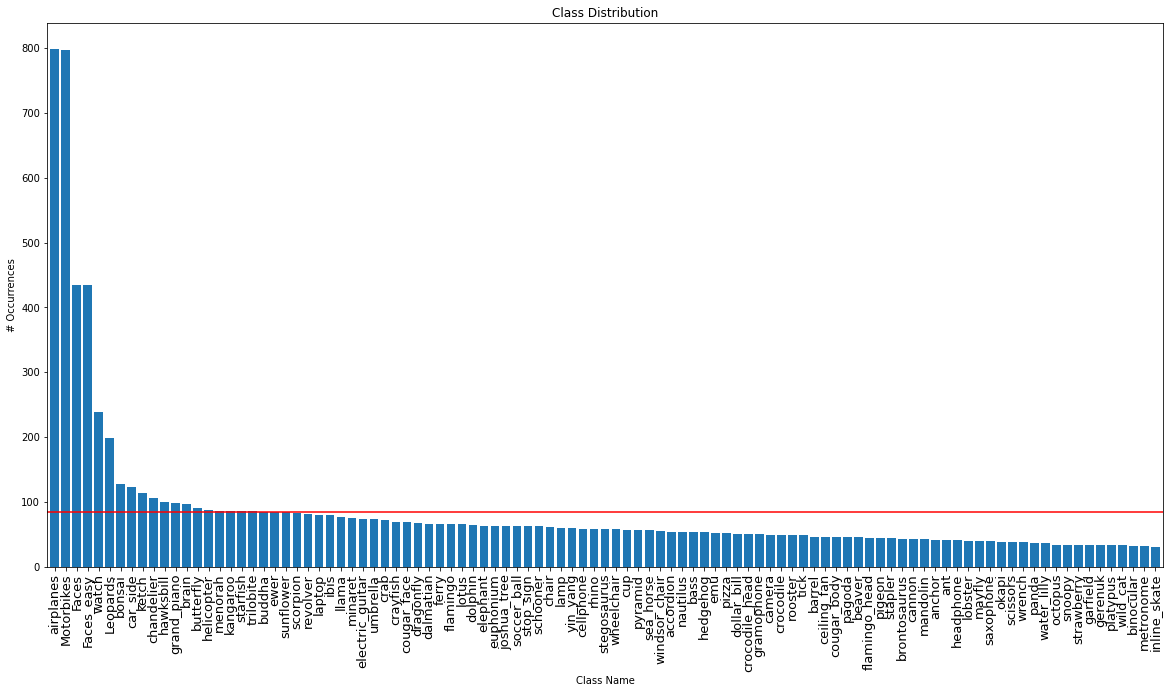

Total Images: 8677
Max # Images in a class: 799
Min # Images in a class: 30
Mean Images for classes: 84.911
STD Images for classes: 117.751


In [0]:
#Remove/Change if statement to plot the class distribution 
if(False):
  classes_size = {}
  elements = 0
  targets = train_dataset.targets + val_dataset.targets + test_dataset.targets
  class_to_idx = train_dataset.class_to_idx 
  for i in targets:
    class_name = next((name for name, index in class_to_idx.items() if index == i), None)
    elements += 1
    if class_name not in classes_size:
      classes_size[class_name] = 0
    else:
      classes_size[class_name] = classes_size[class_name] + 1

  sorted_classes = dict(sorted(classes_size.items(), key=lambda x: x[1],reverse=True))
  fig, ax = plt.subplots(figsize=(20,10))
  x_pos = np.arange(len(train_dataset.classes))
  ax.set_xticks(x_pos)
  ax.set_xticklabels(list(sorted_classes.keys()),rotation='vertical', fontsize=13)

  plt.axhline(np.mean(list(classes_size.values())), c='r' )

  l , r = plt.xlim()
  value = 0.7
  plt.xlim( l-value, r+value )

  plt.bar(x_pos,sorted_classes.values())
  plt.title('Class Distribution')
  plt.xlabel('Class Name')
  plt.ylabel('# Occurrences')
  plt.show()

  print('Total Images: {}'.format(elements))
  print('Max # Images in a class: {}'.format(max(classes_size.values())))
  print('Min # Images in a class: {}'.format(min(classes_size.values())))
  print('Mean Images for classes: {:.3f}'.format(np.mean(list(classes_size.values()))))
  print('STD Images for classes: {:.3f}'.format(np.std(list(classes_size.values()))))

# Prepare Dataloaders

In [0]:
def PrepareDataLoaders():
  # Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
  train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
  val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

  test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

  return train_dataloader, val_dataloader, test_dataloader
train_dataloader, val_dataloader, test_dataloader = PrepareDataLoaders()

In [0]:
def NumParamsToTrain(net):
  # Find total parameters and trainable parameters
  total_params = sum(p.numel() for p in net.parameters())
  print(f'{total_params:,} total parameters.')
  total_trainable_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
  print(f'{total_trainable_params:,} training parameters.')
  diff = total_params-total_trainable_params
  print(f'{diff:,} frozen parameters.')
  ratio = total_trainable_params/total_params
  print(f'{ratio:.2f} ratio training/total.')

# Prepare Network

In [0]:
net = alexnet() # Loading AlexNet model

# AlexNet has 1000 output neurons, corresponding to the 1000 ImageNet's classes
# We need 101 outputs for Caltech-101
net.classifier[6] = nn.Linear(4096, NUM_CLASSES) # nn.Linear in pytorch is a fully connected layer
                                                # The convolutional layer is nn.Conv2d

# We just changed the last layer of AlexNet with a new fully connected layer with 101 outputs
# It is strongly suggested to study torchvision.models.alexnet source code

# Prepare Training

In [0]:
# Define loss function
criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy

# Choose parameters to optimize
# To access a different set of parameters, you have to access submodules of AlexNet
# (nn.Module objects, like AlexNet, implement the Composite Pattern)
# e.g.: parameters of the fully connected layers: net.classifier.parameters()
# e.g.: parameters of the convolutional layers: look at alexnet's source code ;) 
parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet

# Define optimizer
# An optimizer updates the weights based on loss
# We use SGD with momentum
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

# Define scheduler
# A scheduler dynamically changes learning rate
# The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

# Validation

In [0]:
def Validation(model, dataloader):
  model = model.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
  model.train(False) # Set Network to evaluation mode

  running_corrects = 0
  for images, labels in (dataloader):#tqdm
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    # Forward Pass
    outputs = model(images)

    loss = criterion(outputs, labels)
    max = 6
    loss_value = loss.item() if loss.item()<max else max

    # Get predictions
    _, preds = torch.max(outputs.data, 1)
    
    # Update Corrects
    running_corrects += torch.sum(preds == labels.data).data.item()

  # Calculate Accuracy
  accuracy = running_corrects / float(len(dataloader.dataset))

  print('*** Validation Accuracy: {} ***'.format(accuracy))

  return (accuracy, loss_value)

# Train

In [0]:
PATH_MODELS = 'Models/'
if not os.path.isdir('./'+PATH_MODELS):
  os.mkdir('./'+PATH_MODELS)
def Training(net, meta =''):
  # By default, everything is loaded to cpu
  model = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda

  cudnn.benchmark # Calling this optimizes runtime

  current_step = 0
  current_epoch = 0
  loss_value = 0
  # Start iterating over the epochs

  #Test and Validation Loss and Accuracy
  train = []
  valid = []
  best_acc = -9999
  for epoch in range(NUM_EPOCHS):
    print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_lr()))

    running_corrects = 0
    # Iterate over the dataset
    for images, labels in train_dataloader:
      #net.train(True)
      # Bring data over the device of choice
      images = images.to(DEVICE)
      labels = labels.to(DEVICE)

      net.train() # Sets module in training mode

      # PyTorch, by default, accumulates gradients after each backward pass
      # We need to manually set the gradients to zero before starting a new iteration
      optimizer.zero_grad() # Zero-ing the gradients

      # Forward pass to the network
      outputs = net(images)

      # Compute loss based on output and ground truth
      loss = criterion(outputs, labels)
      max = 6
      loss_value = loss.item() if loss.item()<max else max

      # Get predictions
      _, preds = torch.max(outputs.data, 1)
      
      # Update Corrects
      running_corrects += torch.sum(preds == labels.data).data.item()

      # Log loss
      if current_step % LOG_FREQUENCY == 0:
        print('Step {}, Loss {}'.format( current_step, loss_value ))

      # Compute gradients for each layer and update weights
      loss.backward()  # backward pass: computes gradients
      optimizer.step() # update weights based on accumulated gradients

      current_step += 1

    # Calculate Accuracy
    accuracy = running_corrects / float(len(train_dataset))

    #Store training values each epoch
    train.append( (accuracy, loss_value) )

    
    #Evaluate the model each epoch and store the values
    acc_val = 0
    loss_val = 0
    if current_epoch % VAL_FREQUENCY == 0:
      acc_val, loss_val = Validation(net,val_dataloader)
      valid.append( (acc_val , loss_val) )

      #Get model with best accuracy
      if(best_acc < acc_val):
        best_acc = acc_val
        torch.save(net, PATH_MODELS+meta+'.pth')

    current_epoch += 1

    # Step the scheduler
    scheduler.step()

  return train, valid, best_acc

In [0]:
NumParamsToTrain(net)

57,417,637 total parameters.
57,417,637 training parameters.
0 frozen parameters.
1.00 ratio training/total.


In [0]:
if(False):
  #Train from scratch
  meta = 'scratch'
  test, valid, best_acc = Training(net,meta)

  print()
  best_net_scratch = torch.load(PATH_MODELS+meta+'.pth')
  print('Best accuracy on Validation set {}'.format(best_acc))
  _ = Validation(best_net_scratch, test_dataloader)

Starting epoch 1/30, LR = [0.001]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step 0, Loss 4.614453315734863
Step 10, Loss 4.61374044418335
*** Validation Accuracy: 0.02731673582295989 ***
Starting epoch 2/30, LR = [0.001]
Step 20, Loss 4.610221862792969
Starting epoch 3/30, LR = [0.001]
Step 30, Loss 4.607734680175781
*** Validation Accuracy: 0.09197786998616875 ***
Starting epoch 4/30, LR = [0.001]
Step 40, Loss 4.603020191192627
Starting epoch 5/30, LR = [0.001]
Step 50, Loss 4.6003737449646
*** Validation Accuracy: 0.09197786998616875 ***
Starting epoch 6/30, LR = [0.001]
Step 60, Loss 4.600042343139648
Starting epoch 7/30, LR = [0.001]
Step 70, Loss 4.593895435333252
*** Validation Accuracy: 0.09197786998616875 ***
Starting epoch 8/30, LR = [0.001]
Step 80, Loss 4.593409061431885
Starting epoch 9/30, LR = [0.001]
Step 90, Loss 4.5971574783325195
*** Validation Accuracy: 0.09197786998616875 ***
Starting epoch 10/30, LR = [0.001]
Step 100, Loss 4.592329025268555
Starting epoch 11/30, LR = [0.001]
Step 110, Loss 4.587480068206787
Step 120, Loss 4.5799431800842

In [0]:
def PlotAccuracyLoss(train, valid, meta=''):
  acc_train = np.array(train)[:,0]
  acc_valid = np.array(valid)[:,0]

  loss_train = np.array(train)[:,1]
  loss_valid = np.array(valid)[:,1]

  epoch_train = [i for i in range(len(acc_train))]
  epoch_val = [i*VAL_FREQUENCY for i in range(len(acc_valid))]

  fig, ax = plt.subplots(1,2,figsize=(13,7))
  size = 10

  color_train = '#ff0000'
  color_val = '#00ff00'

  ax[0].plot(epoch_train,loss_train,color=color_train)
  ax[0].scatter(epoch_train,loss_train,marker='s',s=size,color=color_train)
  ax[0].plot(epoch_val,loss_valid,color=color_val)
  ax[0].scatter(epoch_val,loss_valid,marker='s',s=size,color=color_val)
  ax[0].set_title('Loss Graph')
  ax[0].set_ylabel('Loss')
  ax[0].set_xlabel('Epoch')

  ax[1].plot(epoch_train,acc_train,color=color_train)
  ax[1].scatter(epoch_train,acc_train,marker='s',s=size,color=color_train)
  ax[1].plot(epoch_val,acc_valid,color=color_val)
  ax[1].scatter(epoch_val,acc_valid,marker='s',s=size,color=color_val)
  ax[1].set_title('Accuracy Graph')
  ax[1].set_ylabel('Accuracy')
  ax[1].set_xlabel('Epoch')

  fig.suptitle(meta)
  plt.legend(["Train", "Validation"])

  fig.tight_layout(rect=[0, 0.03, 1, 0.95])
  plt.show()

  print('Min Loss: Train: {:.6f}, Val: {:.6f}'.format( min(loss_train), min(loss_valid) ))
  print('Max Accuracy: Train: {:.6f}, Val: {:.6f}'.format( max(acc_train), max(acc_valid) ))

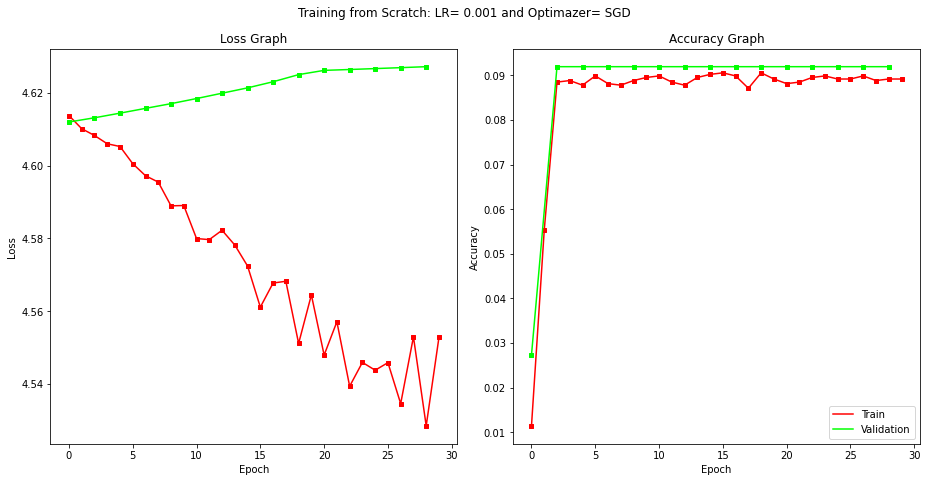

Min Loss: Train: 4.528491, Val: 4.611966
Max Accuracy: Train: 0.090595, Val: 0.091978


In [0]:
if(False):
  meta = 'Training from Scratch: LR= {} and Optimazer= SGD'.format(LR)
  PlotAccuracyLoss(test,valid, meta)

# Training using different parameters

In [0]:
  NUM_EPOCHS = 25
  lr_values = [0.01, 0.001, 0.00001]
  optimazers = ['Adam','RMSprop','SGD']

---  Training with LR = 0.01 and Optimazer = Adam  ---
Starting epoch 1/25, LR = [0.01]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step 0, Loss 4.6136908531188965
Step 10, Loss 6
*** Validation Accuracy: 0.09197786998616875 ***
Starting epoch 2/25, LR = [0.01]
Step 20, Loss 6
Starting epoch 3/25, LR = [0.01]
Step 30, Loss 4.704049587249756
*** Validation Accuracy: 0.08955739972337483 ***
Starting epoch 4/25, LR = [0.01]
Step 40, Loss 6
Starting epoch 5/25, LR = [0.01]
Step 50, Loss 5.388916492462158
*** Validation Accuracy: 0.01313969571230982 ***
Starting epoch 6/25, LR = [0.01]
Step 60, Loss 4.640824317932129
Starting epoch 7/25, LR = [0.01]
Step 70, Loss 4.567932605743408
*** Validation Accuracy: 0.01313969571230982 ***
Starting epoch 8/25, LR = [0.01]
Step 80, Loss 4.557861804962158
Starting epoch 9/25, LR = [0.01]
Step 90, Loss 6
*** Validation Accuracy: 0.09197786998616875 ***
Starting epoch 10/25, LR = [0.01]
Step 100, Loss 4.509162902832031
Starting epoch 11/25, LR = [0.01]
Step 110, Loss 4.488513469696045
Step 120, Loss 4.433873176574707
*** Validation Accuracy: 0.09197786998616875 ***
Starting epoch 12/2

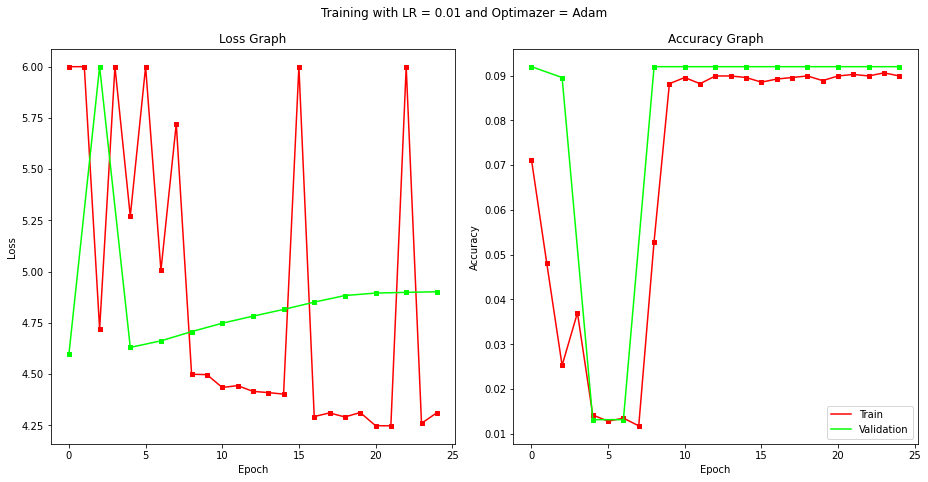

Min Loss: Train: 4.246605, Val: 4.599193
Max Accuracy: Train: 0.090595, Val: 0.091978
---  --- ---  ---

---  Training with LR = 0.01 and Optimazer = RMSprop  ---
Starting epoch 1/25, LR = [0.01]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step 0, Loss 4.614424705505371
Step 10, Loss 6
*** Validation Accuracy: 0.004495159059474412 ***
Starting epoch 2/25, LR = [0.01]
Step 20, Loss 6
Starting epoch 3/25, LR = [0.01]
Step 30, Loss 6
*** Validation Accuracy: 0.009681881051175657 ***
Starting epoch 4/25, LR = [0.01]
Step 40, Loss 6
Starting epoch 5/25, LR = [0.01]
Step 50, Loss 5.247088432312012
*** Validation Accuracy: 0.01313969571230982 ***
Starting epoch 6/25, LR = [0.01]
Step 60, Loss 5.097468376159668
Starting epoch 7/25, LR = [0.01]
Step 70, Loss 4.760167598724365
*** Validation Accuracy: 0.023167358229598894 ***
Starting epoch 8/25, LR = [0.01]
Step 80, Loss 4.516208648681641
Starting epoch 9/25, LR = [0.01]
Step 90, Loss 4.272144794464111
*** Validation Accuracy: 0.09232365145228216 ***
Starting epoch 10/25, LR = [0.01]
Step 100, Loss 4.31448221206665
Starting epoch 11/25, LR = [0.01]
Step 110, Loss 4.198103427886963
Step 120, Loss 4.129268169403076
*** Validation Accuracy: 0.09232365145228216 ***
Starting epoch 12/

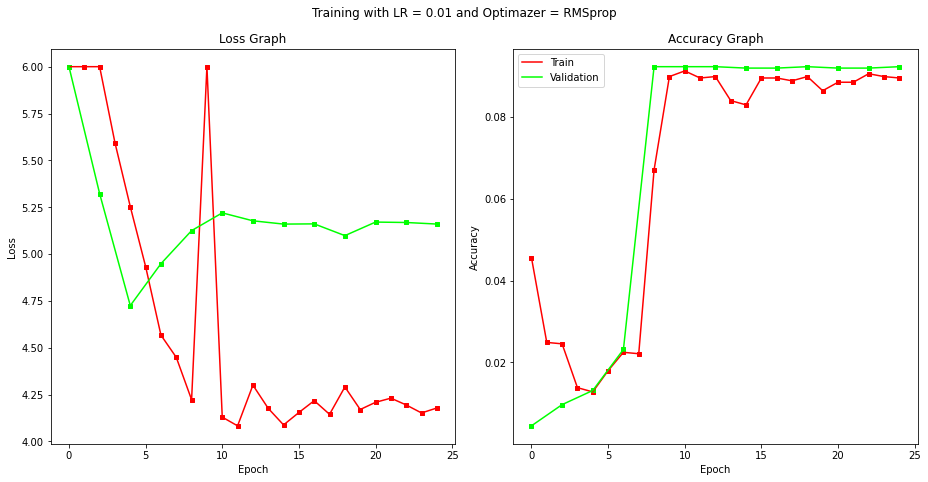

Min Loss: Train: 4.082726, Val: 4.724547
Max Accuracy: Train: 0.091286, Val: 0.092324
---  --- ---  ---

---  Training with LR = 0.01 and Optimazer = SGD  ---
Starting epoch 1/25, LR = [0.01]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step 0, Loss 4.614611625671387
Step 10, Loss 4.603875637054443
*** Validation Accuracy: 0.09197786998616875 ***
Starting epoch 2/25, LR = [0.01]
Step 20, Loss 4.586973667144775
Starting epoch 3/25, LR = [0.01]
Step 30, Loss 4.556102752685547
*** Validation Accuracy: 0.09197786998616875 ***
Starting epoch 4/25, LR = [0.01]
Step 40, Loss 4.48632287979126
Starting epoch 5/25, LR = [0.01]
Step 50, Loss 4.22415018081665
*** Validation Accuracy: 0.09232365145228216 ***
Starting epoch 6/25, LR = [0.01]
Step 60, Loss 4.237237930297852
Starting epoch 7/25, LR = [0.01]
Step 70, Loss 4.216874599456787
*** Validation Accuracy: 0.10200553250345781 ***
Starting epoch 8/25, LR = [0.01]
Step 80, Loss 4.153284072875977
Starting epoch 9/25, LR = [0.01]
Step 90, Loss 4.148904800415039
*** Validation Accuracy: 0.14868603042876902 ***
Starting epoch 10/25, LR = [0.01]
Step 100, Loss 4.065714359283447
Starting epoch 11/25, LR = [0.01]
Step 110, Loss 3.929439067840576
Step 120, Loss 4.113156318664551
*** Val

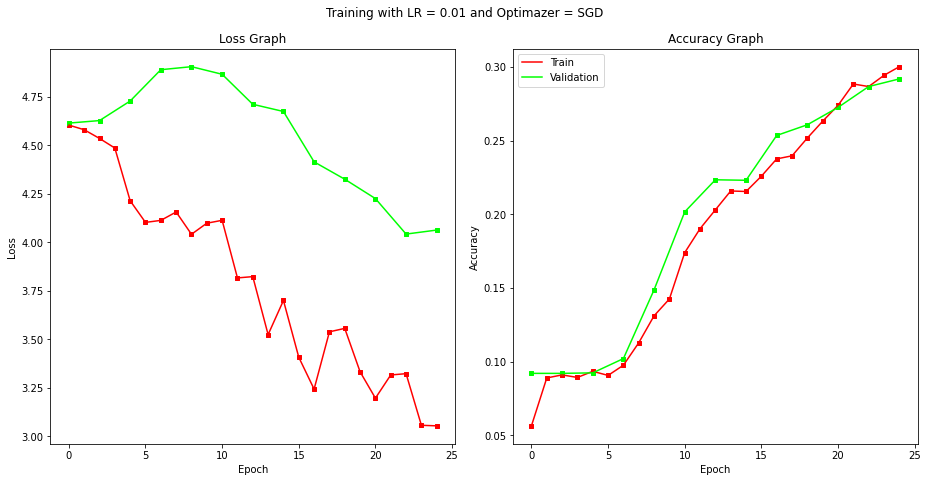

Min Loss: Train: 3.053875, Val: 4.042210
Max Accuracy: Train: 0.300138, Val: 0.291840
---  --- ---  ---

---  Training with LR = 0.001 and Optimazer = Adam  ---
Starting epoch 1/25, LR = [0.001]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step 0, Loss 4.616629600524902
Step 10, Loss 4.460589408874512
*** Validation Accuracy: 0.09232365145228216 ***
Starting epoch 2/25, LR = [0.001]
Step 20, Loss 4.304017543792725
Starting epoch 3/25, LR = [0.001]
Step 30, Loss 4.115827560424805
*** Validation Accuracy: 0.09197786998616875 ***
Starting epoch 4/25, LR = [0.001]
Step 40, Loss 4.005601406097412
Starting epoch 5/25, LR = [0.001]
Step 50, Loss 4.163970947265625
*** Validation Accuracy: 0.15283540802213003 ***
Starting epoch 6/25, LR = [0.001]
Step 60, Loss 3.8599209785461426
Starting epoch 7/25, LR = [0.001]
Step 70, Loss 3.9807074069976807
*** Validation Accuracy: 0.16804979253112035 ***
Starting epoch 8/25, LR = [0.001]
Step 80, Loss 3.8747968673706055
Starting epoch 9/25, LR = [0.001]
Step 90, Loss 3.389845132827759
*** Validation Accuracy: 0.25553250345781464 ***
Starting epoch 10/25, LR = [0.001]
Step 100, Loss 3.7551565170288086
Starting epoch 11/25, LR = [0.001]
Step 110, Loss 3.3199052810668945
Step 120, Loss 3.319818

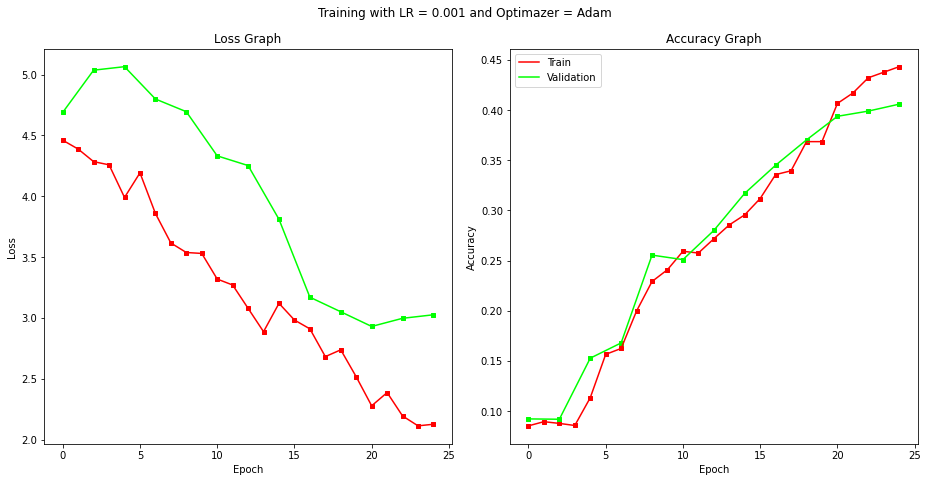

Min Loss: Train: 2.113720, Val: 2.930461
Max Accuracy: Train: 0.443292, Val: 0.405947
---  --- ---  ---

---  Training with LR = 0.001 and Optimazer = RMSprop  ---
Starting epoch 1/25, LR = [0.001]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step 0, Loss 4.618130207061768
Step 10, Loss 6
*** Validation Accuracy: 0.006224066390041493 ***
Starting epoch 2/25, LR = [0.001]
Step 20, Loss 6
Starting epoch 3/25, LR = [0.001]
Step 30, Loss 6
*** Validation Accuracy: 0.007261410788381743 ***
Starting epoch 4/25, LR = [0.001]
Step 40, Loss 6
Starting epoch 5/25, LR = [0.001]
Step 50, Loss 6
*** Validation Accuracy: 0.010027662517289074 ***
Starting epoch 6/25, LR = [0.001]
Step 60, Loss 6
Starting epoch 7/25, LR = [0.001]
Step 70, Loss 4.67744255065918
*** Validation Accuracy: 0.014177040110650069 ***
Starting epoch 8/25, LR = [0.001]
Step 80, Loss 4.637294769287109
Starting epoch 9/25, LR = [0.001]
Step 90, Loss 4.608447074890137
*** Validation Accuracy: 0.014177040110650069 ***
Starting epoch 10/25, LR = [0.001]
Step 100, Loss 4.583395481109619
Starting epoch 11/25, LR = [0.001]
Step 110, Loss 6
Step 120, Loss 4.526282787322998
*** Validation Accuracy: 0.014177040110650069 ***
Starting epoch 12/25, LR = [0.001]
Step 130, Loss 4.4

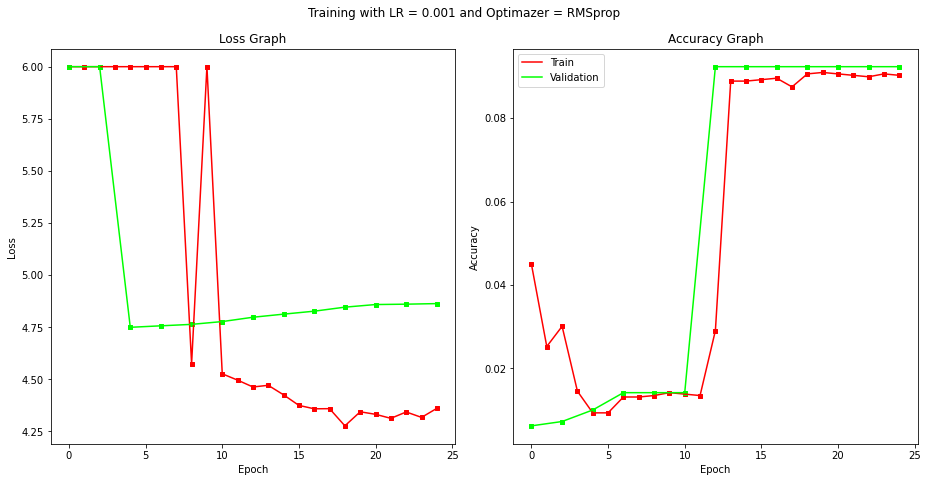

Min Loss: Train: 4.276688, Val: 4.749477
Max Accuracy: Train: 0.090941, Val: 0.092324
---  --- ---  ---

---  Training with LR = 0.001 and Optimazer = SGD  ---
Starting epoch 1/25, LR = [0.001]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step 0, Loss 4.615422248840332
Step 10, Loss 4.613617420196533
*** Validation Accuracy: 0.008298755186721992 ***
Starting epoch 2/25, LR = [0.001]
Step 20, Loss 4.611424446105957
Starting epoch 3/25, LR = [0.001]
Step 30, Loss 4.608787536621094
*** Validation Accuracy: 0.09197786998616875 ***
Starting epoch 4/25, LR = [0.001]
Step 40, Loss 4.604572772979736
Starting epoch 5/25, LR = [0.001]
Step 50, Loss 4.604043483734131
*** Validation Accuracy: 0.09197786998616875 ***
Starting epoch 6/25, LR = [0.001]
Step 60, Loss 4.599658489227295
Starting epoch 7/25, LR = [0.001]
Step 70, Loss 4.597317695617676
*** Validation Accuracy: 0.09197786998616875 ***
Starting epoch 8/25, LR = [0.001]
Step 80, Loss 4.594470024108887
Starting epoch 9/25, LR = [0.001]
Step 90, Loss 4.590054988861084
*** Validation Accuracy: 0.09197786998616875 ***
Starting epoch 10/25, LR = [0.001]
Step 100, Loss 4.588790416717529
Starting epoch 11/25, LR = [0.001]
Step 110, Loss 4.580124378204346
Step 120, Loss 4.5765514373

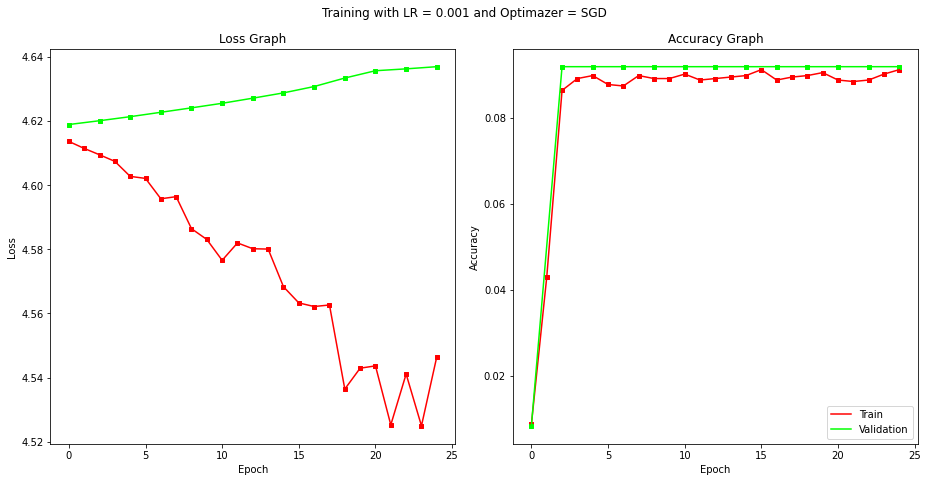

Min Loss: Train: 4.524939, Val: 4.618886
Max Accuracy: Train: 0.091286, Val: 0.091978
---  --- ---  ---

---  Training with LR = 1e-05 and Optimazer = Adam  ---
Starting epoch 1/25, LR = [1e-05]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step 0, Loss 4.615102767944336
Step 10, Loss 4.6017537117004395
*** Validation Accuracy: 0.09197786998616875 ***
Starting epoch 2/25, LR = [1e-05]
Step 20, Loss 4.563483238220215
Starting epoch 3/25, LR = [1e-05]
Step 30, Loss 4.455374240875244
*** Validation Accuracy: 0.09197786998616875 ***
Starting epoch 4/25, LR = [1e-05]
Step 40, Loss 4.442869663238525
Starting epoch 5/25, LR = [1e-05]
Step 50, Loss 4.265339374542236
*** Validation Accuracy: 0.09232365145228216 ***
Starting epoch 6/25, LR = [1e-05]
Step 60, Loss 4.156860828399658
Starting epoch 7/25, LR = [1e-05]
Step 70, Loss 4.257092475891113
*** Validation Accuracy: 0.09301521438450899 ***
Starting epoch 8/25, LR = [1e-05]
Step 80, Loss 4.197352409362793
Starting epoch 9/25, LR = [1e-05]
Step 90, Loss 4.231407642364502
*** Validation Accuracy: 0.1545643153526971 ***
Starting epoch 10/25, LR = [1e-05]
Step 100, Loss 4.195930004119873
Starting epoch 11/25, LR = [1e-05]
Step 110, Loss 3.9583234786987305
Step 120, Loss 4.1585383415

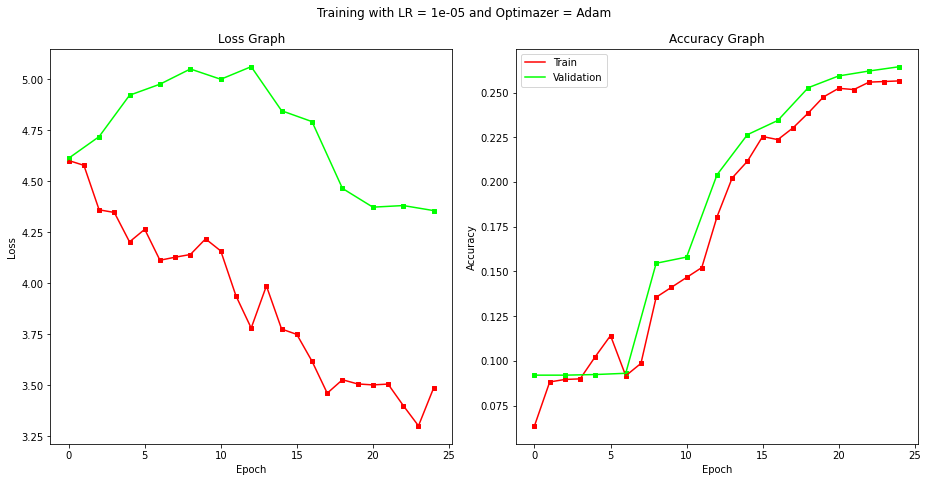

Min Loss: Train: 3.301511, Val: 4.356384
Max Accuracy: Train: 0.256570, Val: 0.264523
---  --- ---  ---

---  Training with LR = 1e-05 and Optimazer = RMSprop  ---
Starting epoch 1/25, LR = [1e-05]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step 0, Loss 4.615046501159668
Step 10, Loss 4.5041184425354
*** Validation Accuracy: 0.02731673582295989 ***
Starting epoch 2/25, LR = [1e-05]
Step 20, Loss 4.285311698913574
Starting epoch 3/25, LR = [1e-05]
Step 30, Loss 4.363101959228516
*** Validation Accuracy: 0.1504149377593361 ***
Starting epoch 4/25, LR = [1e-05]
Step 40, Loss 4.379010200500488
Starting epoch 5/25, LR = [1e-05]
Step 50, Loss 4.154029369354248
*** Validation Accuracy: 0.1462655601659751 ***
Starting epoch 6/25, LR = [1e-05]
Step 60, Loss 3.8800787925720215
Starting epoch 7/25, LR = [1e-05]
Step 70, Loss 3.926567554473877
*** Validation Accuracy: 0.17600276625172892 ***
Starting epoch 8/25, LR = [1e-05]
Step 80, Loss 3.842207908630371
Starting epoch 9/25, LR = [1e-05]
Step 90, Loss 3.820136308670044
*** Validation Accuracy: 0.2548409405255878 ***
Starting epoch 10/25, LR = [1e-05]
Step 100, Loss 3.474160671234131
Starting epoch 11/25, LR = [1e-05]
Step 110, Loss 3.541457176208496
Step 120, Loss 3.079498529434204

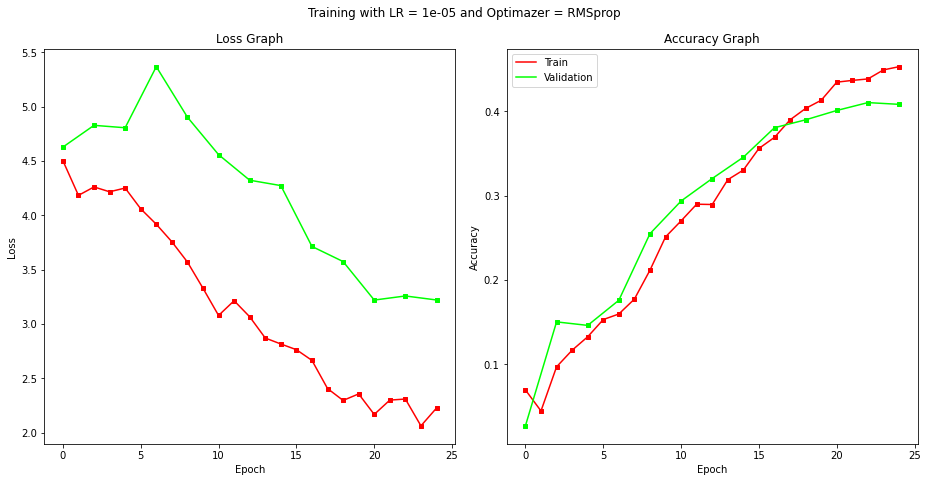

Min Loss: Train: 2.063625, Val: 3.221223
Max Accuracy: Train: 0.452628, Val: 0.410097
---  --- ---  ---

---  Training with LR = 1e-05 and Optimazer = SGD  ---
Starting epoch 1/25, LR = [1e-05]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step 0, Loss 4.615126132965088
Step 10, Loss 4.615061283111572
*** Validation Accuracy: 0.004840940525587829 ***
Starting epoch 2/25, LR = [1e-05]
Step 20, Loss 4.614492416381836
Starting epoch 3/25, LR = [1e-05]
Step 30, Loss 4.615991592407227
*** Validation Accuracy: 0.004840940525587829 ***
Starting epoch 4/25, LR = [1e-05]
Step 40, Loss 4.615346908569336
Starting epoch 5/25, LR = [1e-05]
Step 50, Loss 4.616548538208008
*** Validation Accuracy: 0.004840940525587829 ***
Starting epoch 6/25, LR = [1e-05]
Step 60, Loss 4.615323066711426
Starting epoch 7/25, LR = [1e-05]
Step 70, Loss 4.616104602813721
*** Validation Accuracy: 0.004840940525587829 ***
Starting epoch 8/25, LR = [1e-05]
Step 80, Loss 4.615238189697266
Starting epoch 9/25, LR = [1e-05]
Step 90, Loss 4.615663528442383
*** Validation Accuracy: 0.004840940525587829 ***
Starting epoch 10/25, LR = [1e-05]
Step 100, Loss 4.615499496459961
Starting epoch 11/25, LR = [1e-05]
Step 110, Loss 4.616417407989502
Step 120, Loss 4.614316

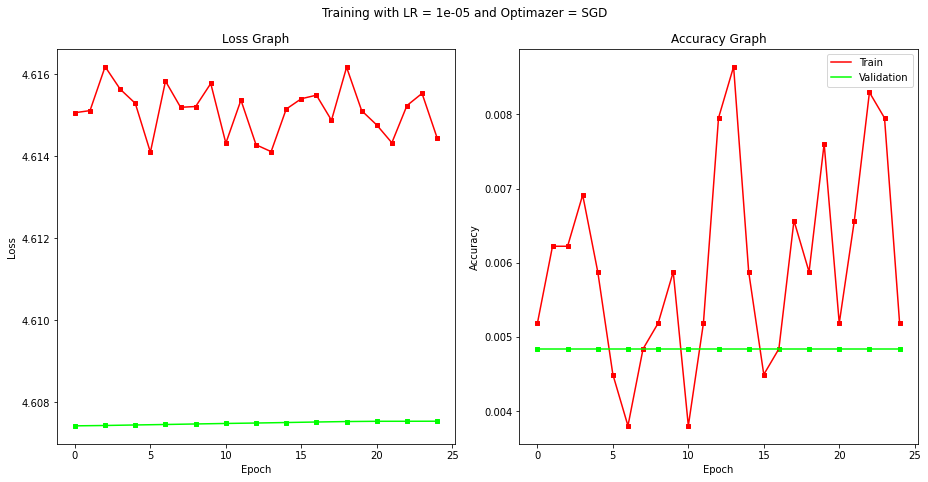

Min Loss: Train: 4.614097, Val: 4.607421
Max Accuracy: Train: 0.008645, Val: 0.004841
---  --- ---  ---



In [0]:
if(False):
  
  scores_scratch = {}
  for lr in lr_values:
    for op in optimazers:

      meta = 'Training with LR = {} and Optimazer = {}'.format(lr,op)
      print('---  {}  ---'.format(meta))

      net_scratch = alexnet()
      net_scratch.classifier[6] = nn.Linear(4096, NUM_CLASSES) 
      criterion = nn.CrossEntropyLoss()

      parameters_to_optimize = net_scratch.parameters()
      if(op == 'Adam'):
        optimizer = optim.Adam(parameters_to_optimize, lr=lr, weight_decay=WEIGHT_DECAY)
      elif(op == 'RMSprop'):
        optimizer = optim.RMSprop(parameters_to_optimize, lr=lr, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
      else:
        optimizer = optim.SGD(parameters_to_optimize, lr=lr, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

      scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

      meta_t = 'scratch_'+str(lr)+'_'+op
      test, valid, best_acc = Training(net_scratch,meta_t)
      PlotAccuracyLoss(test,valid,meta=meta)

      best_net = torch.load(PATH_MODELS+meta_t+'.pth')
      scores_scratch[(lr,op)] = (test,valid, best_acc)

      print('---  --- ---  ---')
      print()


In [0]:
def GetMaxAcc(scores,printAll=False):
  values = dict()
  for k,v in scores.items():
    if(printAll):
      print(k)

    count = 0
    values[k] = []
    train = (0,0)
    val = (0,0)
    for i in v:
      if(count==0):
        train = ( np.min(np.array(i)[:,1]), np.max(np.array(i)[:,0]) )
        if(printAll):
          #print('Train: Min Loss {}'.format(train[0]))
          print('Train: Max Acc {}'.format(train[1]))
      elif(count==1):
        val = ( np.min(np.array(i)[:,1]), np.max(np.array(i)[:,0]) )
        if(printAll):
          print('Val: Min Loss {}'.format(val[0]))
          print('Val: Max Acc {}'.format(val[1]))
      count += 1
    values[k].append(train)
    values[k].append(val)
    if(printAll):
      print('---  ----  ----')
  return values
  
def SketchHeatMap(scores,trainAcc=False):
  score = GetMaxAcc(scores)

  keys = list(score.keys())
  x = sorted(set(i[0] for i in keys),reverse=True)
  y = sorted(set(i[1] for i in keys))

  meta = ''
  if (trainAcc):
    index = 0
    meta = 'Training'
  else: 
    index = 1
    meta = 'Validation'

  values = []
  for v in list(score.values()):
    count = 0
    for i in v:
      if(count==index):
        values.append(i[1]) 
      count += 1

  v = np.reshape(values,(3,3))

  pd_scores = pd.DataFrame(v, index=x, columns=y)
  sns.heatmap(pd_scores, vmin=0, vmax=1, linewidths=.1, annot=True,xticklabels='auto', yticklabels='auto')
  plt.xlabel("Optimizer")
  plt.ylabel("Learning Rate")
  plt.title('HeatMap {} Accuracy'.format(meta))
  plt.show()

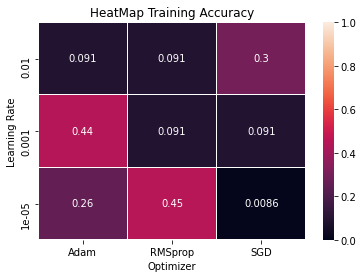

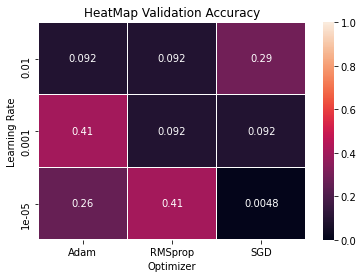

In [0]:
if(False):
  SketchHeatMap(scores_scratch,True)
  SketchHeatMap(scores_scratch)

In [0]:
if(False):
  lr_best = 0.001
  op_best = 'Adam'
  meta_t = 'scratch_'+str(lr_best)+'_'+op_best
  best_net_scratch = torch.load(PATH_MODELS+meta_t+'.pth')
  print('Best accuracy on Validation set {}'.format(scores_scratch[lr_best,op_best][2]))
  _ = Validation(best_net_scratch, test_dataloader)

Best accuracy on Validation set 0.40594744121715076
*** Validation Accuracy: 0.40407881092291736 ***


# Pre-Trainined net

In [0]:
train_transform = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.CenterCrop(224),  # Crops a central square patch of the image
                                                                   # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                   # Remember this when applying different transformations, otherwise you get an error
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) # Normalizes tensor with mean and standard deviation
])
# Define transforms for the evaluation phase
eval_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))                                    
])

train_dataset, val_dataset, test_dataset = PrepareDataset()
train_dataloader, val_dataloader, test_dataloader = PrepareDataLoaders()

Train Dataset: 2892
Valid Dataset: 2892
Train/Valid Dataset Proportion: 1.0 (Required: 1)
Test Dataset: 2893


---  Training with LR = 0.01 and Optimazer = Adam  ---


Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth



Starting epoch 1/25, LR = [0.01]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step 0, Loss 5.055478096008301
Step 10, Loss 6
*** Validation Accuracy: 0.09163208852005532 ***
Starting epoch 2/25, LR = [0.01]
Step 20, Loss 4.394568920135498
Starting epoch 3/25, LR = [0.01]
Step 30, Loss 6
*** Validation Accuracy: 0.09197786998616875 ***
Starting epoch 4/25, LR = [0.01]
Step 40, Loss 6
Starting epoch 5/25, LR = [0.01]
Step 50, Loss 4.2565789222717285
*** Validation Accuracy: 0.09232365145228216 ***
Starting epoch 6/25, LR = [0.01]
Step 60, Loss 6
Starting epoch 7/25, LR = [0.01]
Step 70, Loss 4.436647891998291
*** Validation Accuracy: 0.09197786998616875 ***
Starting epoch 8/25, LR = [0.01]
Step 80, Loss 6
Starting epoch 9/25, LR = [0.01]
Step 90, Loss 4.130654335021973
*** Validation Accuracy: 0.09232365145228216 ***
Starting epoch 10/25, LR = [0.01]
Step 100, Loss 4.199454307556152
Starting epoch 11/25, LR = [0.01]
Step 110, Loss 4.057531356811523
Step 120, Loss 4.273475170135498
*** Validation Accuracy: 0.09647302904564316 ***
Starting epoch 12/25, LR = [0.01]
S

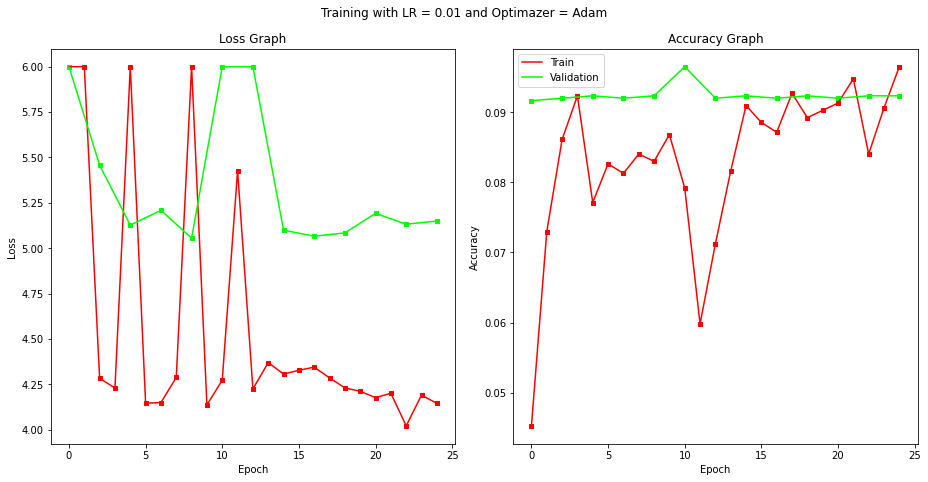

Min Loss: Train: 4.021808, Val: 5.055785
Max Accuracy: Train: 0.096473, Val: 0.096473
---  --- ---  ---

---  Training with LR = 0.01 and Optimazer = RMSprop  ---
Starting epoch 1/25, LR = [0.01]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step 0, Loss 4.845571994781494
Step 10, Loss 6
*** Validation Accuracy: 0.01037344398340249 ***
Starting epoch 2/25, LR = [0.01]
Step 20, Loss 6
Starting epoch 3/25, LR = [0.01]
Step 30, Loss 6
*** Validation Accuracy: 0.05013831258644537 ***
Starting epoch 4/25, LR = [0.01]
Step 40, Loss 6
Starting epoch 5/25, LR = [0.01]
Step 50, Loss 6
*** Validation Accuracy: 0.03561549100968188 ***
Starting epoch 6/25, LR = [0.01]
Step 60, Loss 6
Starting epoch 7/25, LR = [0.01]
Step 70, Loss 6
*** Validation Accuracy: 0.01313969571230982 ***
Starting epoch 8/25, LR = [0.01]
Step 80, Loss 6
Starting epoch 9/25, LR = [0.01]
Step 90, Loss 6
*** Validation Accuracy: 0.007607192254495159 ***
Starting epoch 10/25, LR = [0.01]
Step 100, Loss 6
Starting epoch 11/25, LR = [0.01]
Step 110, Loss 4.784461975097656
Step 120, Loss 6
*** Validation Accuracy: 0.09232365145228216 ***
Starting epoch 12/25, LR = [0.01]
Step 130, Loss 6
Starting epoch 13/25, LR = [0.01]
Step 140, Loss 6
*** Validation Accuracy: 0.09

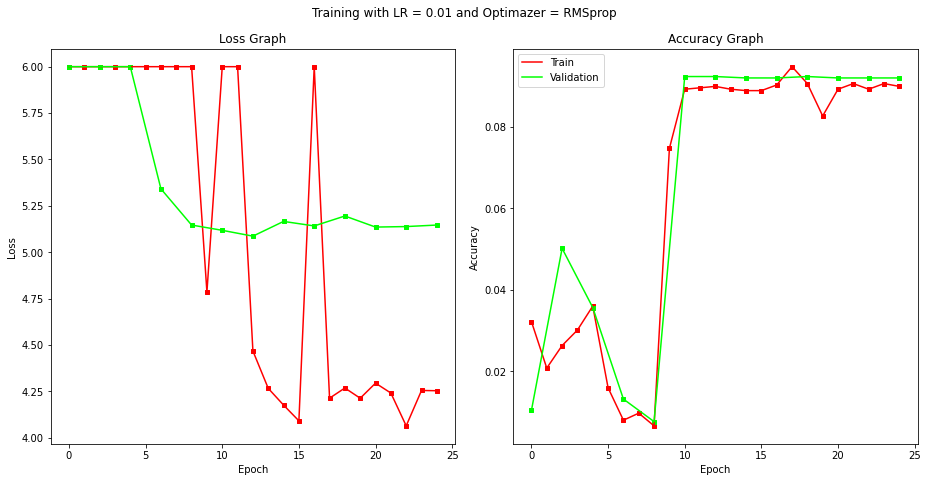

Min Loss: Train: 4.063941, Val: 5.086452
Max Accuracy: Train: 0.094744, Val: 0.092324
---  --- ---  ---

---  Training with LR = 0.01 and Optimazer = SGD  ---
Starting epoch 1/25, LR = [0.01]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step 0, Loss 4.805408000946045
Step 10, Loss 1.8948653936386108
*** Validation Accuracy: 0.6334716459197787 ***
Starting epoch 2/25, LR = [0.01]
Step 20, Loss 0.8138740062713623
Starting epoch 3/25, LR = [0.01]
Step 30, Loss 0.3207128643989563
*** Validation Accuracy: 0.8146611341632088 ***
Starting epoch 4/25, LR = [0.01]
Step 40, Loss 0.15056318044662476
Starting epoch 5/25, LR = [0.01]
Step 50, Loss 0.04579618200659752
*** Validation Accuracy: 0.8302213001383126 ***
Starting epoch 6/25, LR = [0.01]
Step 60, Loss 0.048192236572504044
Starting epoch 7/25, LR = [0.01]
Step 70, Loss 0.04258307069540024
*** Validation Accuracy: 0.8250345781466113 ***
Starting epoch 8/25, LR = [0.01]
Step 80, Loss 0.0853193998336792
Starting epoch 9/25, LR = [0.01]
Step 90, Loss 0.022603578865528107
*** Validation Accuracy: 0.8291839557399724 ***
Starting epoch 10/25, LR = [0.01]
Step 100, Loss 0.043726369738578796
Starting epoch 11/25, LR = [0.01]
Step 110, Loss 0.03532395884394646
Step 120, Loss 0.03861

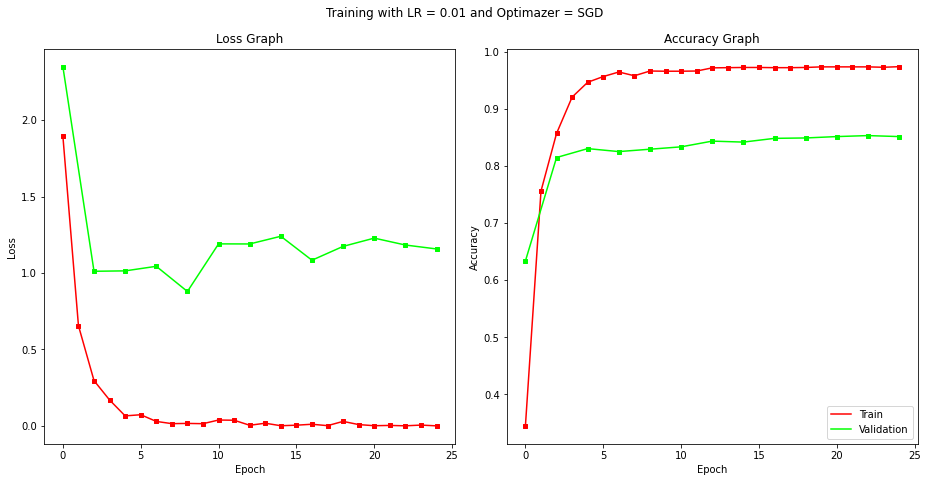

Min Loss: Train: 0.000578, Val: 0.879109
Max Accuracy: Train: 0.973721, Val: 0.853043
---  --- ---  ---

---  Training with LR = 0.001 and Optimazer = Adam  ---
Starting epoch 1/25, LR = [0.001]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step 0, Loss 4.964111328125
Step 10, Loss 3.84924578666687
*** Validation Accuracy: 0.22095435684647302 ***
Starting epoch 2/25, LR = [0.001]
Step 20, Loss 3.318283796310425
Starting epoch 3/25, LR = [0.001]
Step 30, Loss 3.1337499618530273
*** Validation Accuracy: 0.3302213001383126 ***
Starting epoch 4/25, LR = [0.001]
Step 40, Loss 3.009383201599121
Starting epoch 5/25, LR = [0.001]
Step 50, Loss 2.806391954421997
*** Validation Accuracy: 0.42081604426002767 ***
Starting epoch 6/25, LR = [0.001]
Step 60, Loss 2.0744786262512207
Starting epoch 7/25, LR = [0.001]
Step 70, Loss 2.09311580657959
*** Validation Accuracy: 0.5024204702627939 ***
Starting epoch 8/25, LR = [0.001]
Step 80, Loss 1.4398237466812134
Starting epoch 9/25, LR = [0.001]
Step 90, Loss 1.2599190473556519
*** Validation Accuracy: 0.5750345781466113 ***
Starting epoch 10/25, LR = [0.001]
Step 100, Loss 1.1221343278884888
Starting epoch 11/25, LR = [0.001]
Step 110, Loss 0.8879464864730835
Step 120, Loss 0.8604359626770

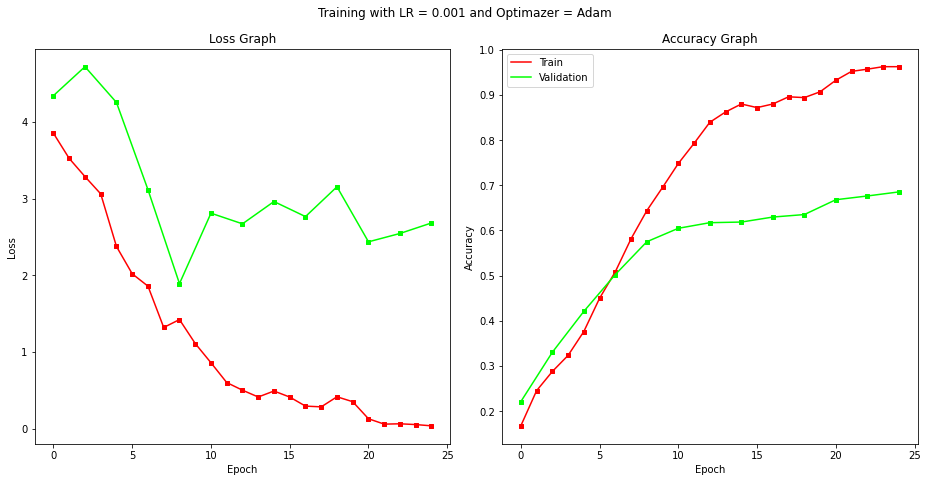

Min Loss: Train: 0.038683, Val: 1.891171
Max Accuracy: Train: 0.962656, Val: 0.685339
---  --- ---  ---

---  Training with LR = 0.001 and Optimazer = RMSprop  ---
Starting epoch 1/25, LR = [0.001]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step 0, Loss 4.824290752410889
Step 10, Loss 6
*** Validation Accuracy: 0.05013831258644537 ***
Starting epoch 2/25, LR = [0.001]
Step 20, Loss 6
Starting epoch 3/25, LR = [0.001]
Step 30, Loss 6
*** Validation Accuracy: 0.005186721991701245 ***
Starting epoch 4/25, LR = [0.001]
Step 40, Loss 6
Starting epoch 5/25, LR = [0.001]
Step 50, Loss 6
*** Validation Accuracy: 0.014177040110650069 ***
Starting epoch 6/25, LR = [0.001]
Step 60, Loss 6
Starting epoch 7/25, LR = [0.001]
Step 70, Loss 6
*** Validation Accuracy: 0.014177040110650069 ***
Starting epoch 8/25, LR = [0.001]
Step 80, Loss 6
Starting epoch 9/25, LR = [0.001]
Step 90, Loss 4.4951605796813965
*** Validation Accuracy: 0.09232365145228216 ***
Starting epoch 10/25, LR = [0.001]
Step 100, Loss 4.451443195343018
Starting epoch 11/25, LR = [0.001]
Step 110, Loss 6
Step 120, Loss 6
*** Validation Accuracy: 0.09232365145228216 ***
Starting epoch 12/25, LR = [0.001]
Step 130, Loss 4.371287822723389
Starting epoch 13/25, LR = [0.001]

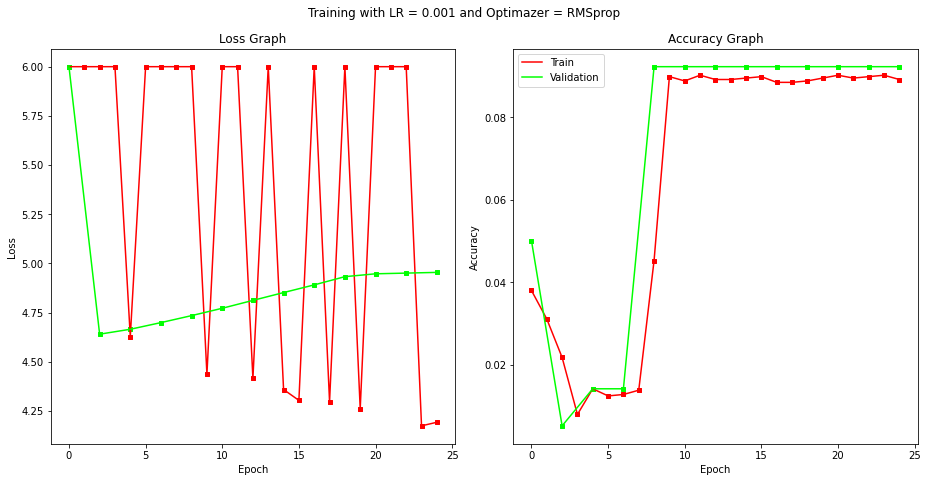

Min Loss: Train: 4.175039, Val: 4.640768
Max Accuracy: Train: 0.090249, Val: 0.092324
---  --- ---  ---

---  Training with LR = 0.001 and Optimazer = SGD  ---
Starting epoch 1/25, LR = [0.001]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step 0, Loss 4.931125164031982
Step 10, Loss 3.49857759475708
*** Validation Accuracy: 0.3032503457814661 ***
Starting epoch 2/25, LR = [0.001]
Step 20, Loss 2.7580296993255615
Starting epoch 3/25, LR = [0.001]
Step 30, Loss 1.918696641921997
*** Validation Accuracy: 0.6047717842323651 ***
Starting epoch 4/25, LR = [0.001]
Step 40, Loss 1.3435022830963135
Starting epoch 5/25, LR = [0.001]
Step 50, Loss 0.7927872538566589
*** Validation Accuracy: 0.7496542185338866 ***
Starting epoch 6/25, LR = [0.001]
Step 60, Loss 0.538225531578064
Starting epoch 7/25, LR = [0.001]
Step 70, Loss 0.3364047706127167
*** Validation Accuracy: 0.803941908713693 ***
Starting epoch 8/25, LR = [0.001]
Step 80, Loss 0.26820310950279236
Starting epoch 9/25, LR = [0.001]
Step 90, Loss 0.20717138051986694
*** Validation Accuracy: 0.8105117565698479 ***
Starting epoch 10/25, LR = [0.001]
Step 100, Loss 0.13190095126628876
Starting epoch 11/25, LR = [0.001]
Step 110, Loss 0.14162655174732208
Step 120, Loss 0.077979

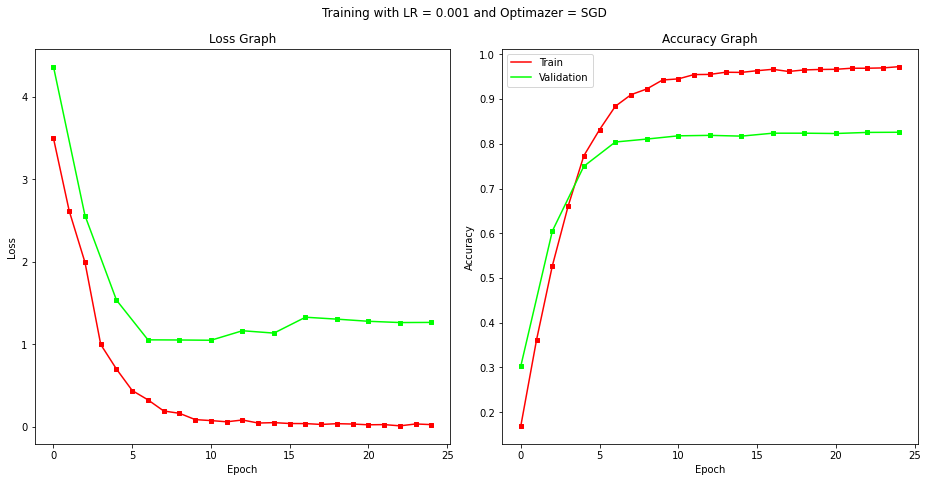

Min Loss: Train: 0.014294, Val: 1.051249
Max Accuracy: Train: 0.972337, Val: 0.825726
---  --- ---  ---

---  Training with LR = 1e-05 and Optimazer = Adam  ---
Starting epoch 1/25, LR = [1e-05]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step 0, Loss 4.77883768081665
Step 10, Loss 4.260360240936279
*** Validation Accuracy: 0.20850622406639005 ***
Starting epoch 2/25, LR = [1e-05]
Step 20, Loss 3.8804495334625244
Starting epoch 3/25, LR = [1e-05]
Step 30, Loss 3.454153537750244
*** Validation Accuracy: 0.31431535269709543 ***
Starting epoch 4/25, LR = [1e-05]
Step 40, Loss 2.981773853302002
Starting epoch 5/25, LR = [1e-05]
Step 50, Loss 2.7408642768859863
*** Validation Accuracy: 0.419432918395574 ***
Starting epoch 6/25, LR = [1e-05]
Step 60, Loss 2.3220903873443604
Starting epoch 7/25, LR = [1e-05]
Step 70, Loss 2.047994613647461
*** Validation Accuracy: 0.5311203319502075 ***
Starting epoch 8/25, LR = [1e-05]
Step 80, Loss 1.7377914190292358
Starting epoch 9/25, LR = [1e-05]
Step 90, Loss 1.5556669235229492
*** Validation Accuracy: 0.6307053941908713 ***
Starting epoch 10/25, LR = [1e-05]
Step 100, Loss 1.2929928302764893
Starting epoch 11/25, LR = [1e-05]
Step 110, Loss 1.0143893957138062
Step 120, Loss 0.873079240

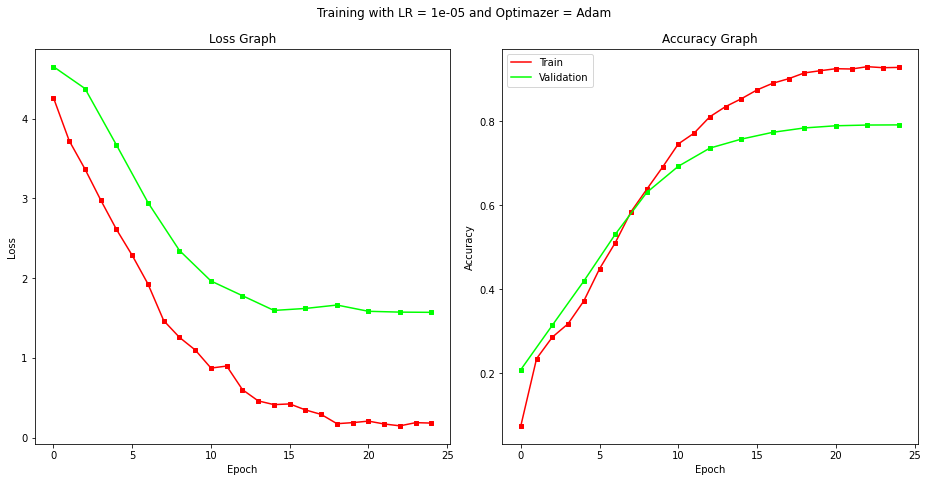

Min Loss: Train: 0.149049, Val: 1.571381
Max Accuracy: Train: 0.930152, Val: 0.791494
---  --- ---  ---

---  Training with LR = 1e-05 and Optimazer = RMSprop  ---
Starting epoch 1/25, LR = [1e-05]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step 0, Loss 4.977695465087891
Step 10, Loss 2.480696678161621
*** Validation Accuracy: 0.5525587828492393 ***
Starting epoch 2/25, LR = [1e-05]
Step 20, Loss 0.5920276045799255
Starting epoch 3/25, LR = [1e-05]
Step 30, Loss 0.3445340394973755
*** Validation Accuracy: 0.8115491009681881 ***
Starting epoch 4/25, LR = [1e-05]
Step 40, Loss 0.12191461026668549
Starting epoch 5/25, LR = [1e-05]
Step 50, Loss 0.06761470437049866
*** Validation Accuracy: 0.8333333333333334 ***
Starting epoch 6/25, LR = [1e-05]
Step 60, Loss 0.04250365495681763
Starting epoch 7/25, LR = [1e-05]
Step 70, Loss 0.02173604816198349
*** Validation Accuracy: 0.8419778699861687 ***
Starting epoch 8/25, LR = [1e-05]
Step 80, Loss 0.006560401059687138
Starting epoch 9/25, LR = [1e-05]
Step 90, Loss 0.006959044840186834
*** Validation Accuracy: 0.8385200553250346 ***
Starting epoch 10/25, LR = [1e-05]
Step 100, Loss 0.004304959438741207
Starting epoch 11/25, LR = [1e-05]
Step 110, Loss 0.011296812444925308
Step 120, L

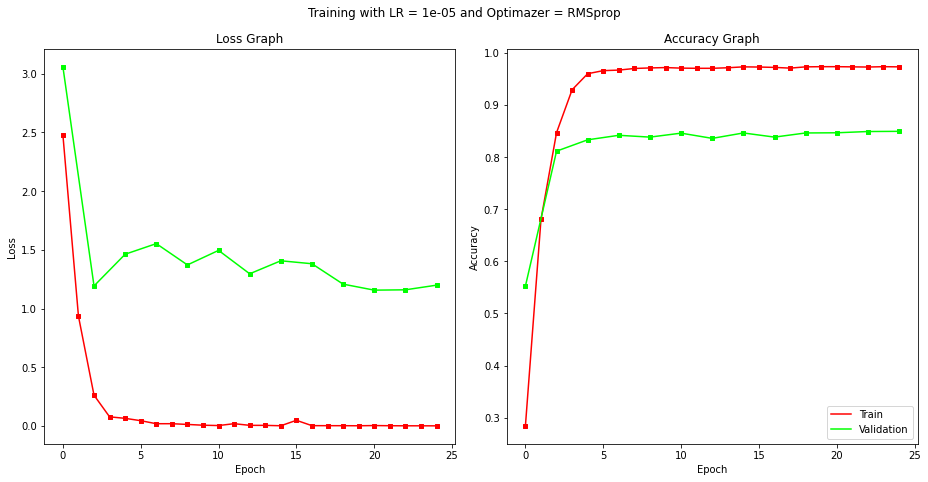

Min Loss: Train: 0.000432, Val: 1.156382
Max Accuracy: Train: 0.973721, Val: 0.849585
---  --- ---  ---

---  Training with LR = 1e-05 and Optimazer = SGD  ---
Starting epoch 1/25, LR = [1e-05]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step 0, Loss 4.966043949127197
Step 10, Loss 5.011992931365967
*** Validation Accuracy: 0.003457814661134163 ***
Starting epoch 2/25, LR = [1e-05]
Step 20, Loss 4.936920642852783
Starting epoch 3/25, LR = [1e-05]
Step 30, Loss 4.843591690063477
*** Validation Accuracy: 0.004495159059474412 ***
Starting epoch 4/25, LR = [1e-05]
Step 40, Loss 4.823496341705322
Starting epoch 5/25, LR = [1e-05]
Step 50, Loss 4.612435817718506
*** Validation Accuracy: 0.02455048409405256 ***
Starting epoch 6/25, LR = [1e-05]
Step 60, Loss 4.5652689933776855
Starting epoch 7/25, LR = [1e-05]
Step 70, Loss 4.579015254974365
*** Validation Accuracy: 0.08748271092669432 ***
Starting epoch 8/25, LR = [1e-05]
Step 80, Loss 4.473969459533691
Starting epoch 9/25, LR = [1e-05]
Step 90, Loss 4.524606227874756
*** Validation Accuracy: 0.15836791147994467 ***
Starting epoch 10/25, LR = [1e-05]
Step 100, Loss 4.319608211517334
Starting epoch 11/25, LR = [1e-05]
Step 110, Loss 4.214035987854004
Step 120, Loss 4.24297094

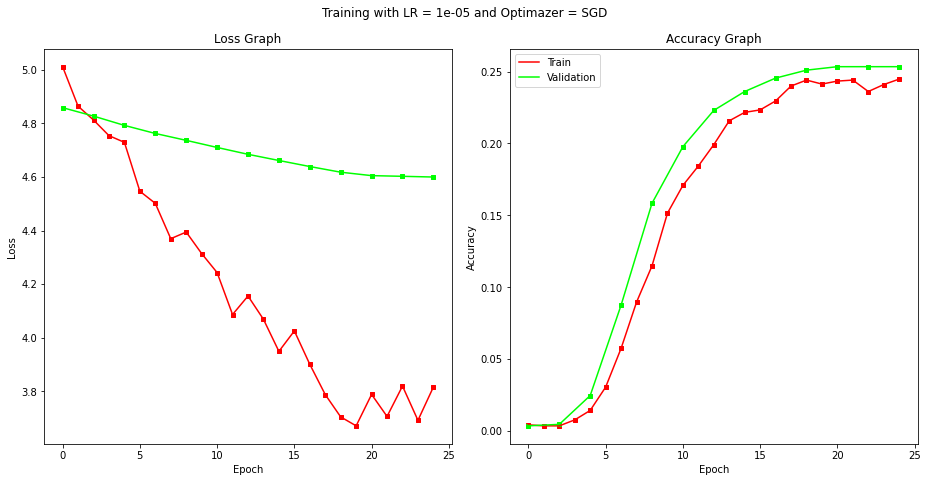

Min Loss: Train: 3.670493, Val: 4.599834
Max Accuracy: Train: 0.244813, Val: 0.253458
---  --- ---  ---



In [0]:
if(False):

  scores = {}
  for lr in lr_values:
    for op in optimazers:

      meta = 'Training with LR = {} and Optimazer = {}'.format(lr,op)
      print('---  {}  ---'.format(meta))

      net = alexnet(pretrained=True)
      net.classifier[6] = nn.Linear(4096, NUM_CLASSES) 
      criterion = nn.CrossEntropyLoss()

      parameters_to_optimize = net.parameters()
      if(op == 'Adam'):
        optimizer = optim.Adam(parameters_to_optimize, lr=lr, weight_decay=WEIGHT_DECAY)
      elif(op == 'RMSprop'):
        optimizer = optim.RMSprop(parameters_to_optimize, lr=lr, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
      else:
        optimizer = optim.SGD(parameters_to_optimize, lr=lr, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

      scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

      meta_t = 'pre_'+str(lr)+'_'+op
      test, valid, best_acc = Training(net,meta_t)
      PlotAccuracyLoss(test,valid,meta=meta)

      best_net = torch.load(PATH_MODELS+meta_t+'.pth')
      scores[(lr,op)] = (test,valid, best_acc)

      print('---  --- ---  ---')
      print()


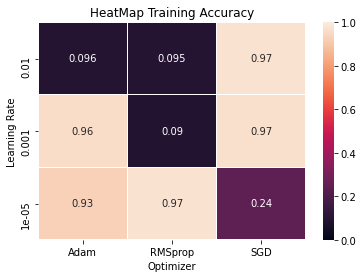

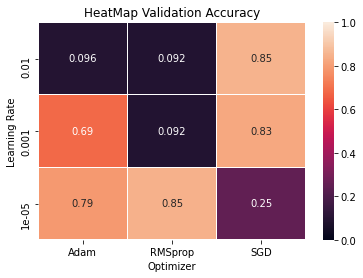

In [0]:
if(False):
  SketchHeatMap(scores,True)
  SketchHeatMap(scores)

In [0]:
#Update NUM_EPOCHS since RMSprop seems to converge before 15/20 epochs
NUM_EPOCHS = 25
best_lr = 0.00001
best_opti = 'RMSprop'

In [0]:
#Test the model on the test dataset using best parameters found
if(False):
  meta_t = 'pre_'+str(best_lr)+'_'+best_opti
  best_net = torch.load(PATH_MODELS+meta_t+'.pth')
  print('Best accuracy on Validation set {}'.format(scores[best_lr,best_opti][2]))
  _ = Validation(best_net, test_dataloader)

Best accuracy on Validation set 0.8495850622406639
*** Validation Accuracy: 0.8486000691323885 ***


## Pre-Trainined net (Fixed CNN)

In [0]:
def FreezeNetwork(net, freeze=0):
  if(freeze!=0 and freeze!= 2):
    print('ERROR INPUT!! Received freeze = {} ### Legend: 0 -> freeze CNN, 2 -> freeze FC ###'.format(freeze))
  else:
    #Set the training for all layers to False
    #freeze: 0 -> freeze FC, 2 -> freeze CNN
    count = 0
    for child in net.children():
      if(count==freeze):#count==freeze
        print('Freezing: {}. ### Legend: 0 -> freeze CNN, 2 -> freeze FC ###'.format(freeze))
        for param in child.parameters():
              param.requires_grad = False
        exit
      count += 1
  #Print anyway the number of parameters
  NumParamsToTrain(net)
  return net

Freezing: 2. ### Legend: 0 -> freeze CNN, 2 -> freeze FC ###
57,417,637 total parameters.
2,469,696 training parameters.
54,947,941 frozen parameters.
0.04 ratio training/total.

Starting epoch 1/25, LR = [1e-05]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step 0, Loss 4.733546733856201
Step 10, Loss 4.003282070159912
*** Validation Accuracy: 0.2206085753803596 ***
Starting epoch 2/25, LR = [1e-05]
Step 20, Loss 3.3511195182800293
Starting epoch 3/25, LR = [1e-05]
Step 30, Loss 3.140392780303955
*** Validation Accuracy: 0.33782849239280777 ***
Starting epoch 4/25, LR = [1e-05]
Step 40, Loss 3.0416321754455566
Starting epoch 5/25, LR = [1e-05]
Step 50, Loss 3.1229000091552734
*** Validation Accuracy: 0.39073305670816044 ***
Starting epoch 6/25, LR = [1e-05]
Step 60, Loss 2.648052930831909
Starting epoch 7/25, LR = [1e-05]
Step 70, Loss 2.580695152282715
*** Validation Accuracy: 0.4287690179806362 ***
Starting epoch 8/25, LR = [1e-05]
Step 80, Loss 2.680523633956909
Starting epoch 9/25, LR = [1e-05]
Step 90, Loss 2.441610097885132
*** Validation Accuracy: 0.4581604426002766 ***
Starting epoch 10/25, LR = [1e-05]
Step 100, Loss 2.368121862411499
Starting epoch 11/25, LR = [1e-05]
Step 110, Loss 2.369431734085083
Step 120, Loss 2.03053903579

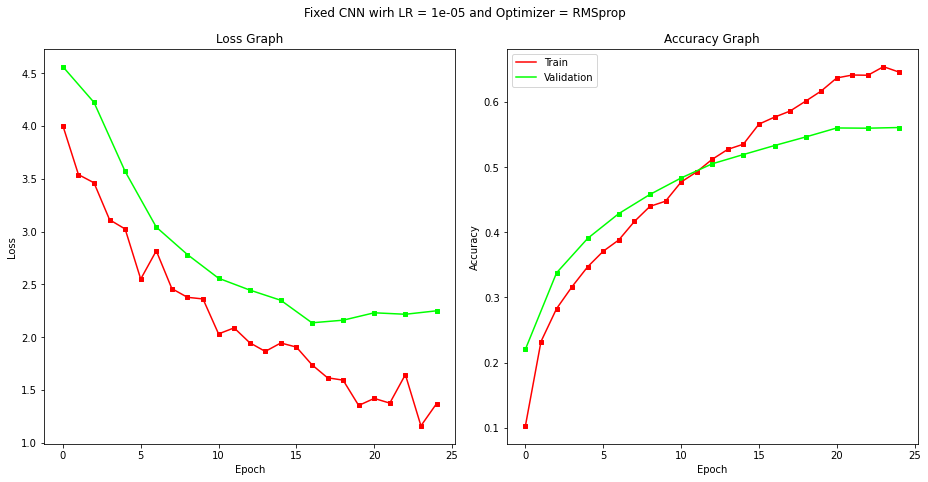

Min Loss: Train: 1.159051, Val: 2.135742
Max Accuracy: Train: 0.654219, Val: 0.560858

Best accuracy on Validation set 0.5608575380359613
*** Validation Accuracy: 0.5516764604217076 ***


In [0]:
if(False):
  net = alexnet(pretrained=True)

  net.classifier[6] = nn.Linear(4096, NUM_CLASSES) 

  net = FreezeNetwork(net,2)

  criterion = nn.CrossEntropyLoss()

  parameters_to_optimize = net.parameters()
  optimizer = optim.RMSprop(parameters_to_optimize, lr=best_lr, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
  scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

  print()
  meta_t = 'fixcnn_'+str(best_lr)+'_'+best_opti
  test, valid, best_acc = Training(net,meta_t)

  print()
  meta = 'Fixed CNN wirh LR = {} and Optimizer = {}'.format(best_lr, best_opti)
  PlotAccuracyLoss(test,valid,meta=meta)

  print()
  best_net = torch.load(PATH_MODELS+meta_t+'.pth')
  print('Best accuracy on Validation set {}'.format(best_acc))
  _ = Validation(best_net, test_dataloader)

## Pre-Trainined net (Fixed FC Layer)

Freezing: 0. ### Legend: 0 -> freeze CNN, 2 -> freeze FC ###
57,417,637 total parameters.
54,947,941 training parameters.
2,469,696 frozen parameters.
0.96 ratio training/total.

Starting epoch 1/25, LR = [1e-05]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step 0, Loss 4.86144495010376
Step 10, Loss 1.8361594676971436
*** Validation Accuracy: 0.6462655601659751 ***
Starting epoch 2/25, LR = [1e-05]
Step 20, Loss 0.43756935000419617
Starting epoch 3/25, LR = [1e-05]
Step 30, Loss 0.17916439473628998
*** Validation Accuracy: 0.8295297372060858 ***
Starting epoch 4/25, LR = [1e-05]
Step 40, Loss 0.07152699679136276
Starting epoch 5/25, LR = [1e-05]
Step 50, Loss 0.03344804421067238
*** Validation Accuracy: 0.8464730290456431 ***
Starting epoch 6/25, LR = [1e-05]
Step 60, Loss 0.02015896514058113
Starting epoch 7/25, LR = [1e-05]
Step 70, Loss 0.011498745530843735
*** Validation Accuracy: 0.8520055325034578 ***
Starting epoch 8/25, LR = [1e-05]
Step 80, Loss 0.013196025975048542
Starting epoch 9/25, LR = [1e-05]
Step 90, Loss 0.01832628808915615
*** Validation Accuracy: 0.8485477178423236 ***
Starting epoch 10/25, LR = [1e-05]
Step 100, Loss 0.008837525732815266
Starting epoch 11/25, LR = [1e-05]
Step 110, Loss 0.012045778334140778
Step 120,

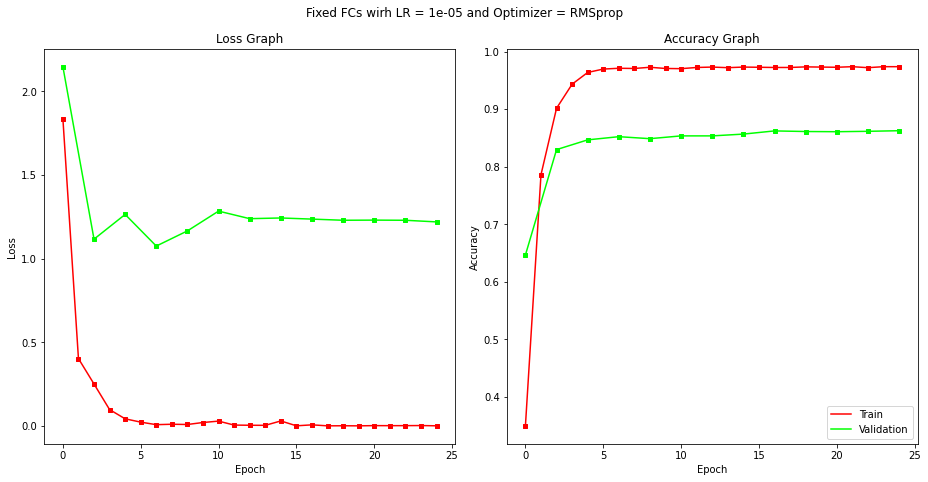

Min Loss: Train: 0.001500, Val: 1.075130
Max Accuracy: Train: 0.973721, Val: 0.862379

Best accuracy on Validation set 0.8623789764868603
*** Validation Accuracy: 0.8510197027307294 ***


In [0]:
if(False):
  net = alexnet(pretrained=True) # Loading AlexNet model

  net.classifier[6] = nn.Linear(4096, NUM_CLASSES) 

  net = FreezeNetwork(net,0)

  criterion = nn.CrossEntropyLoss()

  parameters_to_optimize = net.parameters()
  optimizer = optim.RMSprop(parameters_to_optimize, lr=best_lr, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
  scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

  print()
  meta_t = 'fixfc_'+str(best_lr)+'_'+best_opti
  test, valid, best_acc = Training(net,meta_t)

  print()
  meta = 'Fixed FCs wirh LR = {} and Optimizer = {}'.format(best_lr, best_opti)
  PlotAccuracyLoss(test,valid,meta=meta)

  print()
  best_net = torch.load(PATH_MODELS+meta_t+'.pth')
  print('Best accuracy on Validation set {}'.format(best_acc))
  _ = Validation(best_net, test_dataloader)

# Augmented Dataset

In [0]:
def TrainingAug(net, meta =''):
  showImage=True
  # By default, everything is loaded to cpu
  model = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda

  cudnn.benchmark # Calling this optimizes runtime

  current_step = 0
  current_epoch = 0
  loss_value = 0
  # Start iterating over the epochs

  #Test and Validation Loss and Accuracy
  train = []
  valid = []
  best_acc = -9999
  for epoch in range(NUM_EPOCHS):
    print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_lr()))

    running_corrects = 0
    # Iterate over the dataset
    for images, labels in train_dataloader:
      #net.train(True)
      # Bring data over the device of choice
      images = images.to(DEVICE)
      labels = labels.to(DEVICE)

      if(showImage):
        invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])

        inv_tensor_0 = invTrans(images[0])
        plt.imshow(np.transpose(inv_tensor_0.cpu().detach().numpy(), (1, 2, 0)))
        plt.show()
        inv_tensor_5 = invTrans(images[5])
        plt.imshow(np.transpose(inv_tensor_5.cpu().detach().numpy(), (1, 2, 0)))
        plt.show()
        inv_tensor_10 = invTrans(images[10])
        plt.imshow(np.transpose(inv_tensor_10.cpu().detach().numpy(), (1, 2, 0)))
        plt.show()
        inv_tensor_15 = invTrans(images[15])
        plt.imshow(np.transpose(inv_tensor_15.cpu().detach().numpy(), (1, 2, 0)))
        plt.show()
        showImage = False

      net.train() # Sets module in training mode

      # PyTorch, by default, accumulates gradients after each backward pass
      # We need to manually set the gradients to zero before starting a new iteration
      optimizer.zero_grad() # Zero-ing the gradients

      # Forward pass to the network
      outputs = net(images)

      # Compute loss based on output and ground truth
      loss = criterion(outputs, labels)
      max = 6
      loss_value = loss.item() if loss.item()<max else max

      # Get predictions
      _, preds = torch.max(outputs.data, 1)
      
      # Update Corrects
      running_corrects += torch.sum(preds == labels.data).data.item()

      # Log loss
      if current_step % LOG_FREQUENCY == 0:
        print('Step {}, Loss {}'.format( current_step, loss_value ))

      # Compute gradients for each layer and update weights
      loss.backward()  # backward pass: computes gradients
      optimizer.step() # update weights based on accumulated gradients

      current_step += 1

    # Calculate Accuracy
    accuracy = running_corrects / float(len(train_dataset))

    #Store training values each epoch
    train.append( (accuracy, loss_value) )

    
    #Evaluate the model each epoch and store the values
    acc_val = 0
    loss_val = 0
    if current_epoch % VAL_FREQUENCY == 0:
      acc_val, loss_val = Validation(net,val_dataloader)
      valid.append( (acc_val , loss_val) )

      #Get model with best accuracy
      if(best_acc < acc_val):
        best_acc = acc_val
        torch.save(net, PATH_MODELS+meta+'.pth')

    current_epoch += 1

    # Step the scheduler
    scheduler.step()

  return train, valid, best_acc

Augmentation with transformation: Horizontal Flip
Train Dataset: 2892
Valid Dataset: 2892
Train/Valid Dataset Proportion: 1.0 (Required: 1)
Test Dataset: 2893

Starting epoch 1/25, LR = [1e-05]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


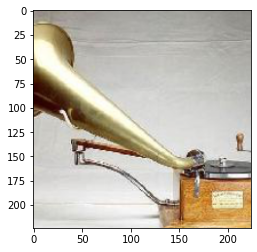

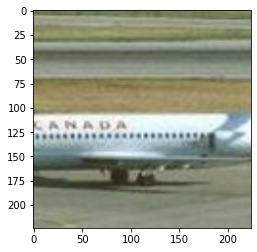

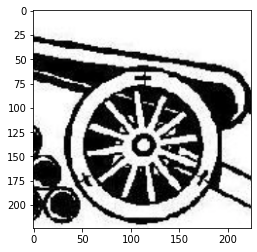

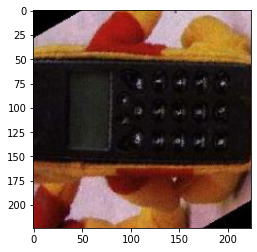

Step 0, Loss 4.914149284362793
Step 10, Loss 2.134524345397949
*** Validation Accuracy: 0.5504840940525588 ***
Starting epoch 2/25, LR = [1e-05]
Step 20, Loss 0.7265046834945679
Starting epoch 3/25, LR = [1e-05]
Step 30, Loss 0.2788698971271515
*** Validation Accuracy: 0.7710926694329184 ***
Starting epoch 4/25, LR = [1e-05]
Step 40, Loss 0.11776801198720932
Starting epoch 5/25, LR = [1e-05]
Step 50, Loss 0.037788912653923035
*** Validation Accuracy: 0.7991009681881052 ***
Starting epoch 6/25, LR = [1e-05]
Step 60, Loss 0.010974172502756119
Starting epoch 7/25, LR = [1e-05]
Step 70, Loss 0.01549281645566225
*** Validation Accuracy: 0.8087828492392808 ***
Starting epoch 8/25, LR = [1e-05]
Step 80, Loss 0.021477917209267616
Starting epoch 9/25, LR = [1e-05]
Step 90, Loss 0.019753707572817802
*** Validation Accuracy: 0.808091286307054 ***
Starting epoch 10/25, LR = [1e-05]
Step 100, Loss 0.004423948936164379
Starting epoch 11/25, LR = [1e-05]
Step 110, Loss 0.02066897787153721
Step 120, L

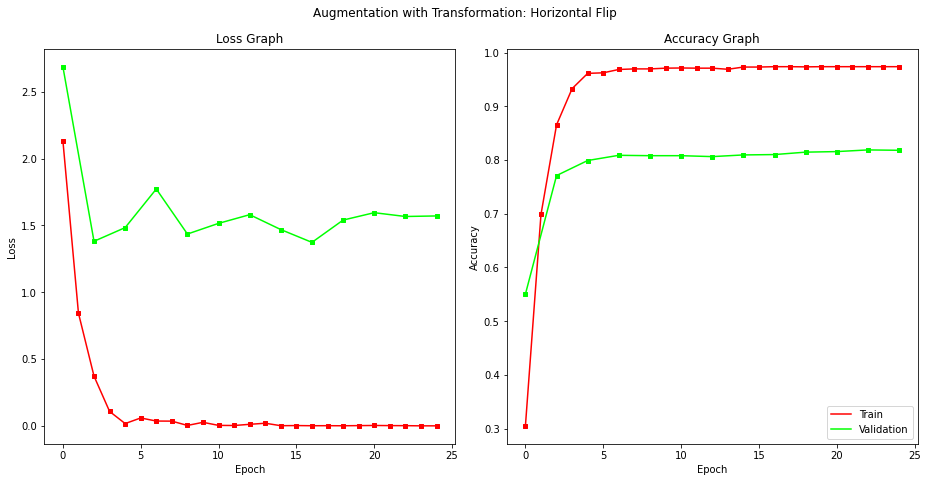

Min Loss: Train: 0.000239, Val: 1.372759
Max Accuracy: Train: 0.973721, Val: 0.818811

Best accuracy on Validation set 0.8188105117565698
*** Validation Accuracy: 0.8226754234358797 ***

Augmentation with transformation: Rotation
Train Dataset: 2892
Valid Dataset: 2892
Train/Valid Dataset Proportion: 1.0 (Required: 1)
Test Dataset: 2893

Starting epoch 1/25, LR = [1e-05]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


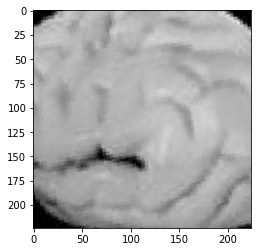

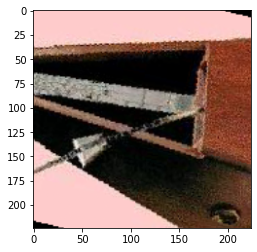

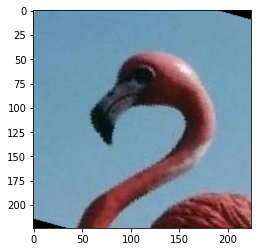

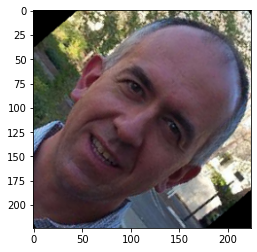

Step 0, Loss 4.816775321960449
Step 10, Loss 2.896497964859009
*** Validation Accuracy: 0.4284232365145228 ***
Starting epoch 2/25, LR = [1e-05]
Step 20, Loss 1.478346347808838
Starting epoch 3/25, LR = [1e-05]
Step 30, Loss 1.3914711475372314
*** Validation Accuracy: 0.7005532503457814 ***
Starting epoch 4/25, LR = [1e-05]
Step 40, Loss 0.7609652876853943
Starting epoch 5/25, LR = [1e-05]
Step 50, Loss 0.5014955997467041
*** Validation Accuracy: 0.7465421853388658 ***
Starting epoch 6/25, LR = [1e-05]
Step 60, Loss 0.40593385696411133
Starting epoch 7/25, LR = [1e-05]
Step 70, Loss 0.2848338484764099
*** Validation Accuracy: 0.7638312586445366 ***
Starting epoch 8/25, LR = [1e-05]
Step 80, Loss 0.23997202515602112
Starting epoch 9/25, LR = [1e-05]
Step 90, Loss 0.20542553067207336
*** Validation Accuracy: 0.7742047026279392 ***
Starting epoch 10/25, LR = [1e-05]
Step 100, Loss 0.11729130148887634
Starting epoch 11/25, LR = [1e-05]
Step 110, Loss 0.13621379435062408
Step 120, Loss 0.07

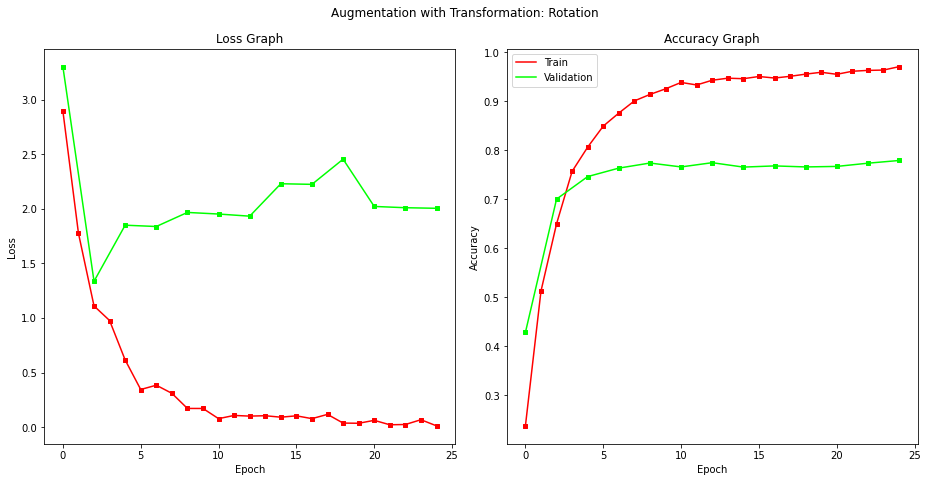

Min Loss: Train: 0.013196, Val: 1.337052
Max Accuracy: Train: 0.970954, Val: 0.779391

Best accuracy on Validation set 0.7793914246196404
*** Validation Accuracy: 0.7742827514690632 ***

Augmentation with transformation: Vertical Flip
Train Dataset: 2892
Valid Dataset: 2892
Train/Valid Dataset Proportion: 1.0 (Required: 1)
Test Dataset: 2893

Starting epoch 1/25, LR = [1e-05]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


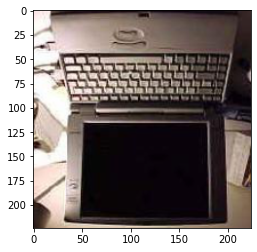

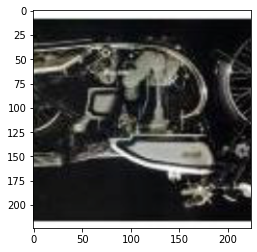

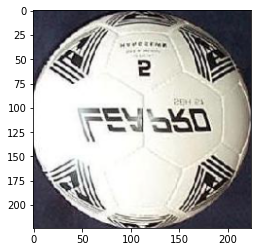

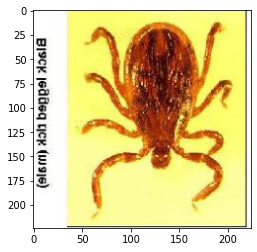

Step 0, Loss 4.940613269805908
Step 10, Loss 2.582981824874878
*** Validation Accuracy: 0.46749654218533887 ***
Starting epoch 2/25, LR = [1e-05]
Step 20, Loss 1.049439549446106
Starting epoch 3/25, LR = [1e-05]
Step 30, Loss 0.570374608039856
*** Validation Accuracy: 0.6044260027662517 ***
Starting epoch 4/25, LR = [1e-05]
Step 40, Loss 0.18585562705993652
Starting epoch 5/25, LR = [1e-05]
Step 50, Loss 0.09630805999040604
*** Validation Accuracy: 0.6390041493775933 ***
Starting epoch 6/25, LR = [1e-05]
Step 60, Loss 0.04542312026023865
Starting epoch 7/25, LR = [1e-05]
Step 70, Loss 0.016260262578725815
*** Validation Accuracy: 0.6206777316735823 ***
Starting epoch 8/25, LR = [1e-05]
Step 80, Loss 0.022081665694713593
Starting epoch 9/25, LR = [1e-05]
Step 90, Loss 0.009266000241041183
*** Validation Accuracy: 0.648686030428769 ***
Starting epoch 10/25, LR = [1e-05]
Step 100, Loss 0.006343810819089413
Starting epoch 11/25, LR = [1e-05]
Step 110, Loss 0.007037515752017498
Step 120, Lo

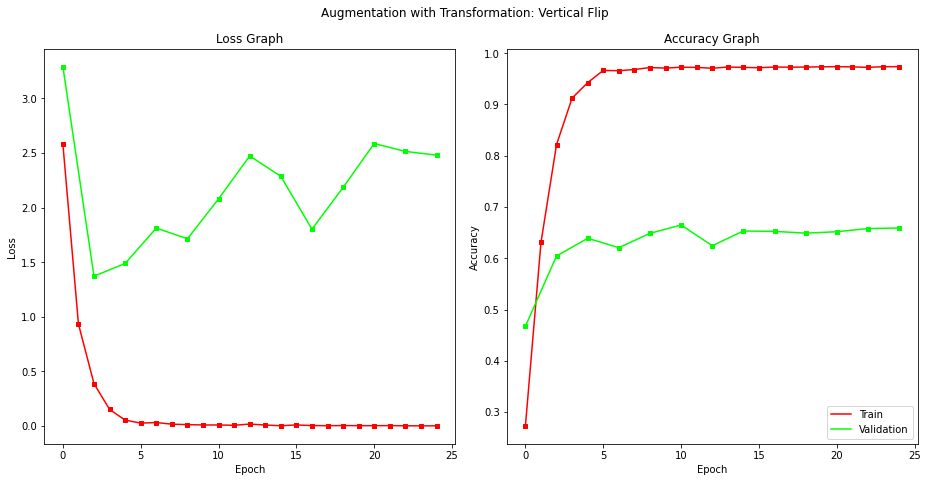

Min Loss: Train: 0.000344, Val: 1.371769
Max Accuracy: Train: 0.973721, Val: 0.664938

Best accuracy on Validation set 0.6649377593360996
*** Validation Accuracy: 0.6681645350846872 ***



In [0]:
if(False):
  '''in any epoch the dataloader will apply a fresh set of random operations “on the fly”.
  So instead of showing the exact same items at every epoch,
  you are showing a variant that has been changed in a different way.
  So after three epochs, you would have seen three random variants of each item in a dataset.'''

  # Define transforms for training phase
  train_transformations = []
  train_transform_1 = transforms.Compose([transforms.RandomHorizontalFlip(1),
                                        transforms.Resize(256),      
                                        transforms.CenterCrop(224),                         
                                                                    
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
  ])
  train_transformations.append( ('Horizontal Flip',train_transform_1) )

  angle = 90
  train_transform_2 = transforms.Compose([transforms.RandomRotation([-angle,angle]),
                                        transforms.Resize(256),      
                                        transforms.CenterCrop(224),                         
                                                                    
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
  ])
  train_transformations.append( ('Rotation',train_transform_2) )

  train_transform_3 = transforms.Compose([transforms.RandomVerticalFlip(1),
                                        transforms.Resize(256),      
                                        transforms.CenterCrop(224),                         
                                                                    
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
  ])
  train_transformations.append( ('Vertical Flip',train_transform_3) )

  # Define transforms for the evaluation phase
  eval_transform = transforms.Compose([transforms.Resize(256),
                                        transforms.CenterCrop(224),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))                                    
  ])

  for t in range(len(train_transformations)):
    print('Augmentation with transformation: {}'.format(train_transformations[t][0]))

    train_transform = train_transformations[t][1]
    train_dataset, val_dataset, test_dataset = PrepareDataset()
    train_dataloader, val_dataloader, test_dataloader = PrepareDataLoaders()

    net = alexnet(pretrained=True) # Loading AlexNet model

    net.classifier[6] = nn.Linear(4096, NUM_CLASSES) 

    #net = FreezeNetwork(net,0)

    criterion = nn.CrossEntropyLoss()

    parameters_to_optimize = net.parameters()
    optimizer = optim.RMSprop(parameters_to_optimize, lr=best_lr, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

    print()
    meta_t = 'augm'+str(t)
    test, valid, best_acc = TrainingAug(net,meta_t)

    print()
    meta = 'Augmentation with Transformation: {}'.format(train_transformations[t][0])
    PlotAccuracyLoss(test,valid,meta=meta)

    print()
    best_net = torch.load(PATH_MODELS+meta_t+'.pth')
    print('Best accuracy on Validation set {}'.format(best_acc))
    _ = Validation(best_net, test_dataloader)
    print()

# (EXTRA) Beyond AlexNet

In [0]:
train_transform = transforms.Compose([transforms.Resize(256),      
                                      transforms.CenterCrop(224),                         
                                                                   
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])
# Define transforms for the evaluation phase
eval_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))                                    
])

train_dataset, val_dataset, test_dataset = PrepareDataset()

Train Dataset: 2892
Valid Dataset: 2892
Train/Valid Dataset Proportion: 1.0 (Required: 1)
Test Dataset: 2893


## VGG16

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth



142,757,397 total parameters.
8,496,853 training parameters.
134,260,544 frozen parameters.
0.06 ratio training/total.

Starting epoch 1/30, LR = [0.000125]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step 0, Loss 4.713724136352539
Step 10, Loss 4.629474639892578
Step 20, Loss 4.625776290893555
Step 30, Loss 4.531065464019775
Step 40, Loss 4.480916976928711
Step 50, Loss 4.566519260406494
Step 60, Loss 4.4844841957092285
Step 70, Loss 4.194655895233154
Step 80, Loss 4.244098663330078
*** Validation Accuracy: 0.1912171507607192 ***
Starting epoch 2/30, LR = [0.000125]
Step 90, Loss 4.2269062995910645
Step 100, Loss 4.054935455322266
Step 110, Loss 4.215295314788818
Step 120, Loss 3.995518922805786
Step 130, Loss 4.069991588592529
Step 140, Loss 4.075493812561035
Step 150, Loss 4.032130718231201
Step 160, Loss 3.8885293006896973
Step 170, Loss 3.7012581825256348
Starting epoch 3/30, LR = [0.000125]
Step 180, Loss 3.9704689979553223
Step 190, Loss 4.266875743865967
Step 200, Loss 3.0823800563812256
Step 210, Loss 3.4458553791046143
Step 220, Loss 3.614380359649658
Step 230, Loss 3.598947763442993
Step 240, Loss 3.741060495376587
Step 250, Loss 3.8422250747680664
Step 260, Loss 3.760323

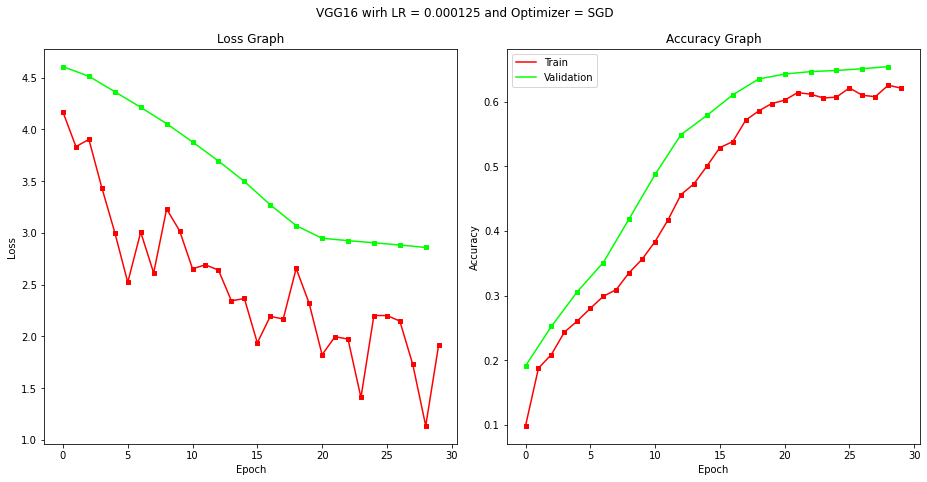

Min Loss: Train: 1.135335, Val: 2.859460
Max Accuracy: Train: 0.625173, Val: 0.653873

Best accuracy on Validation set 0.6538727524204703
*** Validation Accuracy: 0.6629796059453854 ***


In [0]:
from torchvision.models import vgg16
net = vgg16(pretrained=True)


#Print the number of Weights
#net = FreezeNetwork(net,1)

for child in net.children():
  for param in child.parameters():
    param.requires_grad = False
    
net.classifier[6] = nn.Sequential(
                      nn.Linear(4096, 2024), 
                      nn.ReLU(), 
                      nn.Dropout(0.4),
                      nn.Linear(2024, NUM_CLASSES),                   
                      nn.LogSoftmax(dim=1))

NumParamsToTrain(net)

criterion = nn.CrossEntropyLoss()

BATCH_SIZE = 256
factor = 8
BATCH_SIZE = int(BATCH_SIZE / factor)
LR = LR / factor

train_dataloader, val_dataloader, test_dataloader = PrepareDataLoaders()

parameters_to_optimize = net.parameters()
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

print()
meta_t = 'vgg'+str(LR)+'_'+'SGD'
test, valid, best_acc = Training(net,meta_t)

print()
meta = 'VGG16 wirh LR = {} and Optimizer = {}'.format(LR, 'SGD')
PlotAccuracyLoss(test,valid,meta=meta)


print()
best_net = torch.load(PATH_MODELS+meta_t+'.pth')
print('Best accuracy on Validation set {}'.format(best_acc))
_ = Validation(best_net, test_dataloader)

## RESNET18

ERROR INPUT!! Received freeze = -1 ### Legend: 0 -> freeze CNN, 2 -> freeze FC ###
13,691,557 total parameters.
13,691,557 training parameters.
0 frozen parameters.
1.00 ratio training/total.

Starting epoch 1/30, LR = [0.001]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Step 0, Loss 4.639541149139404
Step 10, Loss 4.153716087341309
*** Validation Accuracy: 0.17047026279391425 ***
Starting epoch 2/30, LR = [0.001]
Step 20, Loss 3.625298261642456
Starting epoch 3/30, LR = [0.001]
Step 30, Loss 3.484454393386841
*** Validation Accuracy: 0.2970262793914246 ***
Starting epoch 4/30, LR = [0.001]
Step 40, Loss 3.130471706390381
Starting epoch 5/30, LR = [0.001]
Step 50, Loss 2.9552791118621826
*** Validation Accuracy: 0.37793914246196403 ***
Starting epoch 6/30, LR = [0.001]
Step 60, Loss 2.864637851715088
Starting epoch 7/30, LR = [0.001]
Step 70, Loss 2.8781566619873047
*** Validation Accuracy: 0.4854771784232365 ***
Starting epoch 8/30, LR = [0.001]
Step 80, Loss 2.552244186401367
Starting epoch 9/30, LR = [0.001]
Step 90, Loss 2.529985189437866
*** Validation Accuracy: 0.5795297372060858 ***
Starting epoch 10/30, LR = [0.001]
Step 100, Loss 2.272413730621338
Starting epoch 11/30, LR = [0.001]
Step 110, Loss 2.161240339279175
Step 120, Loss 2.131961345672

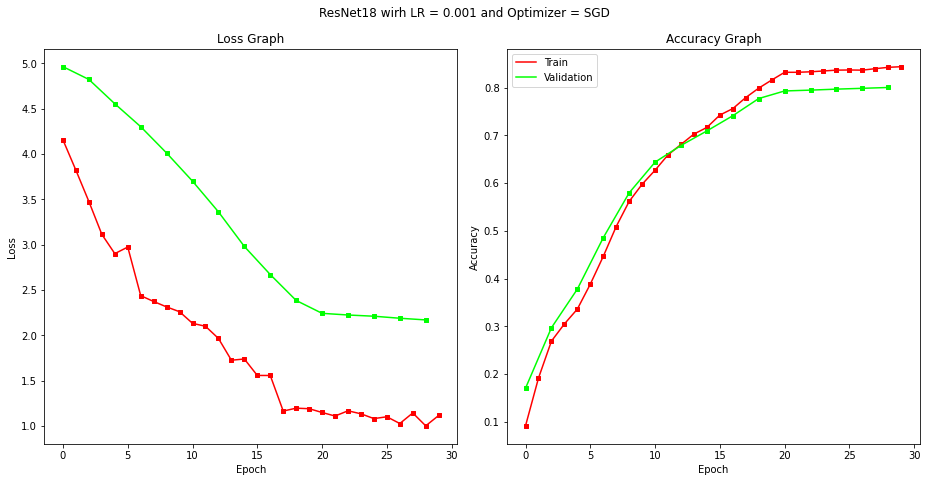

Min Loss: Train: 1.002164, Val: 2.169843
Max Accuracy: Train: 0.843707, Val: 0.800138

Best accuracy on Validation set 0.8001383125864454
*** Validation Accuracy: 0.8060836501901141 ***


In [0]:
from torchvision.models import resnet18
from collections import OrderedDict

net = resnet18(pretrained=True)

#Add FC Layer
fc = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(512,4096)),
    ('relu', nn.ReLU()),
    ('fc2', nn.Linear(4096,NUM_CLASSES)),
    ('output', nn.LogSoftmax(dim=1))
]))

net.fc = fc

#Print the number of Weights
net = FreezeNetwork(net,-1)

criterion = nn.CrossEntropyLoss()

BATCH_SIZE = 256
LR = 0.001

#Depending on which GPU Google Colab assign, you may need to reduce the batch size (factor of 2 is enough)
'''
factor = 2
BATCH_SIZE = int(BATCH_SIZE / factor)
LR = LR / factor
''' 

train_dataloader, val_dataloader, test_dataloader = PrepareDataLoaders()

parameters_to_optimize = net.parameters()
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)


print()
meta_t = 'resn'+str(LR)+'_'+'SGD'
test, valid, best_acc = Training(net,meta_t)

print()
meta = 'ResNet18 wirh LR = {} and Optimizer = {}'.format(LR, 'SGD')
PlotAccuracyLoss(test,valid,meta=meta)


print()
best_net = torch.load(PATH_MODELS+meta_t+'.pth')
print('Best accuracy on Validation set {}'.format(best_acc))
_ = Validation(best_net, test_dataloader)